## 1. 환경 설정

### (1) Env 환경변수


In [1]:

from dotenv import load_dotenv
import os
# .env 파일을 불러와서 환경 변수로 설정
load_dotenv(dotenv_path='../.env')

OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")
print(OPENAI_API_KEY[:2])

sk


In [2]:

### (2) 기본 라이브러리
import re
import os, json
from glob import glob
import pickle

from textwrap import dedent
from pprint import pprint

import uuid

import warnings
warnings.filterwarnings("ignore")


## 2. 법률 문서를 로드하여 벡터저장소에 저장

In [3]:

# pdf 파일 목록을 확인
pdf_files = glob(os.path.join('../data/legal', '*.pdf'))
pdf_files


['../data/legal\\개인정보 보호법(법률)(제19234호)(20240315).pdf',
 '../data/legal\\근로기준법(법률)(제18176호)(20211119).pdf',
 '../data/legal\\주택임대차보호법(법률)(제19356호)(20230719).pdf']

### 2-1. 개인정보보호법
#### PDf 문서를 가져와서 조항 별로 구분하여 정리

In [4]:

from langchain_community.document_loaders import PyPDFLoader

pdf_file = '../data/legal/개인정보 보호법(법률)(제19234호)(20240315).pdf'

loader = PyPDFLoader(pdf_file)
pages = loader.load()

print(len(pages))

print(pages[0].page_content)

print(pages[0].metadata)

print(pages[0].page_content)

def parse_law(law_text):
    # 서문 분리
    # '^'로 시작하여 '제1장' 또는 '제1조' 직전까지의 모든 텍스트를 탐색 
    preamble_pattern = r'^(.*?)(?=제1장|제1조)'
    preamble = re.search(preamble_pattern, law_text, re.DOTALL)
    if preamble:
        preamble = preamble.group(1).strip()
    
    # 장 분리 
    # '제X장' 형식의 제목과 그 뒤에 오는 모든 조항을 하나의 그룹화 
    chapter_pattern = r'(제\d+장\s+.+?)\n((?:제\d+조(?:의\d+)?(?:\(\w+\))?.*?)(?=제\d+장|부칙|$))'
    chapters = re.findall(chapter_pattern, law_text, re.DOTALL)
    
    # 부칙 분리
    # '부칙'으로 시작하는 모든 텍스트를 탐색 
    appendix_pattern = r'(부칙.*)'
    appendix = re.search(appendix_pattern, law_text, re.DOTALL)
    if appendix:
        appendix = appendix.group(1)
    
    # 파싱 결과를 저장할 딕셔너리 초기화
    parsed_law = {'서문': preamble, '장': {}, '부칙': appendix}
    
    # 각 장 내에서 조 분리
    for chapter_title, chapter_content in chapters:
        # 조 분리 패턴
        # 1. '제X조'로 시작 ('제X조의Y' 형식도 가능)
        # 2. 조 번호 뒤에 반드시 '(항목명)' 형식의 제목이 와야 함 
        # 3. 다음 조가 시작되기 전까지 또는 문서의 끝까지의 모든 내용을 포함
        article_pattern = r'(제\d+조(?:의\d+)?\s*\([^)]+\).*?)(?=제\d+조(?:의\d+)?\s*\([^)]+\)|$)'
        
        # 정규표현식을 이용해 모든 조항을 탐색 
        articles = re.findall(article_pattern, chapter_content, re.DOTALL)
        
        # 각 조항의 앞뒤 공백을 제거하고 결과 딕셔너리에 저장
        parsed_law['장'][chapter_title.strip()] = [article.strip() for article in articles]
    
    return parsed_law


# 각 페이지의 텍스트를 결합하여 재분리
text_for_delete = r"법제처\s+\d+\s+국가법령정보센터\n개인정보 보호법"

law_text = "\n".join([re.sub(text_for_delete, "", p.page_content).strip() for p in pages])

parsed_law = parse_law(law_text)

# 분할된 아이템 갯수 확인
print(len(parsed_law["장"]))
print(parsed_law)


41
법제처                                                            1                                                       국가법령정보센터
개인정보 보호법
 
개인정보 보호법
[시행 2024. 3. 15.] [법률 제19234호, 2023. 3. 14., 일부개정]
개인정보보호위원회 (심사총괄담당관 - 일반 법령해석) 02-2100-3043
개인정보보호위원회 (국제협력담당관 - 국외이전) 02-2100-2484, 2499
개인정보보호위원회 (개인정보보호정책과 - 법령 제ㆍ개정, 아동ㆍ청소년) 02-2100-3057, 3047
개인정보보호위원회 (신기술개인정보과 - 영상정보, 안전조치) 02-2100-3064, 3028
개인정보보호위원회 (데이터안전정책과 - 가명정보, 개인정보안심구역) 02-2100-3088, 3074, 3058, 3079
개인정보보호위원회 (자율보호정책과 - 보호책임자, 자율규제, 보호수준 평가, 처리방침, 영향평가) 02-2100-3083, 3089, 3087, 3096,
3086
개인정보보호위원회 (분쟁조정과 - 분쟁조정, 손해배상책임) 1833-6972, 02-2100-3142
개인정보보호위원회 (범정부마이데이터 추진단(전략기획팀 - 전송요구권(마이데이터)) 02-2100-3173
       제1장 총칙
 
제1조(목적) 이 법은 개인정보의 처리 및 보호에 관한 사항을 정함으로써 개인의 자유와 권리를 보호하고, 나아가 개인
의 존엄과 가치를 구현함을 목적으로 한다. <개정 2014. 3. 24.>
 
제2조(정의) 이 법에서 사용하는 용어의 뜻은 다음과 같다. <개정 2014. 3. 24., 2020. 2. 4., 2023. 3. 14.>
1. “개인정보”란 살아 있는 개인에 관한 정보로서 다음 각 목의 어느 하나에 해당하는 정보를 말한다.
가. 성명, 주민등록번호 및 영상 등을 통하여 개인을 알아볼 수 있는 정보
나. 해당 정보만으로는 특정

#### 랭체인 Document 객체에 메타데이터와 함께 정리

In [5]:

from langchain_core.documents import Document

final_docs = []
for law in parsed_law['장'].keys():
    for article in parsed_law['장'][law]:

        # metadata 내용을 정리 
        metadata = {
                "source": pdf_file,
                "chapter": law,
                "name" : "개인정보 보호법"
                }

        # metadata 내용을 본문에 추가 
        content = f"[법률정보]\n다음 조항은 {metadata['name']} {metadata['chapter']}에서 발췌한 내용입니다.\n\n[법률조항]\n{article}"

        final_docs.append(Document(page_content=content, metadata=metadata))
        
print(len(final_docs))

print(final_docs[0].page_content)
print()
print(final_docs[0].metadata)

print(final_docs[-1].page_content)
print()
print(final_docs[-1].metadata)

# 각 문서의 텍스트 길이를 확인
text_lengths = [len(d.page_content) for d in final_docs]
print(min(text_lengths), max(text_lengths))


109
[법률정보]
다음 조항은 개인정보 보호법 제1장 총칙에서 발췌한 내용입니다.

[법률조항]
제1조(목적) 이 법은 개인정보의 처리 및 보호에 관한 사항을 정함으로써 개인의 자유와 권리를 보호하고, 나아가 개인
의 존엄과 가치를 구현함을 목적으로 한다. <개정 2014. 3. 24.>

{'source': '../data/legal/개인정보 보호법(법률)(제19234호)(20240315).pdf', 'chapter': '제1장 총칙', 'name': '개인정보 보호법'}
[법률정보]
다음 조항은 개인정보 보호법 제10장 벌칙 <개정 2020. 2. 4.>에서 발췌한 내용입니다.

[법률조항]
제76조(과태료에 관한 규정 적용의 특례) 제75조의 과태료에 관한 규정을 적용할 때 제64조의2에 따라 과징금을 부과
한 행위에 대하여는 과태료를 부과할 수 없다. <개정 2023. 3. 14.>
[본조신설 2013. 8. 6.]

{'source': '../data/legal/개인정보 보호법(법률)(제19234호)(20240315).pdf', 'chapter': '제10장 벌칙 <개정 2020. 2. 4.>', 'name': '개인정보 보호법'}
116 2824


#### 벡터저장소에 인덱싱

In [6]:

from langchain_community.vectorstores import FAISS
from langchain_ollama import OllamaEmbeddings

embeddings_model = OllamaEmbeddings(model="bge-m3")

# FAISS 인덱스 생성
personal_db = FAISS.from_documents(
    documents=final_docs, 
    embedding=embeddings_model
)

# FAISS 인덱스 저장
os.makedirs("../db/legal_db", exist_ok=True)
personal_db.save_local("../db/legal_db/personal_law")

### 2-2. 근로기준법
#### PDf 문서를 가져와서 조항 별로 구분하여 정리

In [7]:

from langchain_community.document_loaders import PyPDFLoader

pdf_file = '../data/legal/근로기준법(법률)(제18176호)(20211119).pdf'

loader = PyPDFLoader(pdf_file)
pages = loader.load()

print(len(pages))

print(pages[0].page_content)

# 각 페이지의 텍스트를 결합하여 재분리
text_for_delete = r"법제처\s+\d+\s+국가법령정보센터\n근로기준법"

law_text = "\n".join([re.sub(text_for_delete, "", p.page_content).strip() for p in pages])

parsed_law = parse_law(law_text)

# 분할된 아이템 갯수 확인
print(len(parsed_law["장"]))
print(parsed_law)

#### 랭체인 Document 객체에 메타데이터와 함께 정리

from langchain_core.documents import Document

final_docs = []
for law in parsed_law['장'].keys():
    for article in parsed_law['장'][law]:

        # metadata 내용을 정리 
        metadata = {
                "source": pdf_file,
                "chapter": law,
                "name" : "근로기준법"
                }

        # metadata 내용을 본문에 추가 
        content = f"[법률정보]\n다음 조항은 {metadata['name']} {metadata['chapter']}에서 발췌한 내용입니다.\n\n[법률조항]\n{article}"

        final_docs.append(Document(page_content=content, metadata=metadata))
        
print(len(final_docs))

print(final_docs[0].page_content)
print()
print(final_docs[0].metadata)

print(final_docs[1].page_content)
print()
print(final_docs[1].metadata)

#### 벡터저장소에 인덱싱


# 각 문서의 텍스트 길이를 확인
text_lengths = [len(d.page_content) for d in final_docs]
print(min(text_lengths), max(text_lengths))

from langchain_community.vectorstores import FAISS
from langchain_ollama import OllamaEmbeddings

embeddings_model = OllamaEmbeddings(model="bge-m3")

# FAISS 인덱스 생성
labor_db = FAISS.from_documents(
    documents=final_docs, 
    embedding=embeddings_model
)

# FAISS 인덱스 저장
labor_db.save_local("../db/legal_db/labor_law")


20
법제처                                                            1                                                       국가법령정보센터
근로기준법
 
근로기준법
[시행 2021. 11. 19.] [법률 제18176호, 2021. 5. 18., 일부개정]
고용노동부 (근로기준정책과 - 해고, 취업규칙, 기타) 044-202-7534
고용노동부 (근로기준정책과 - 소년) 044-202-7535
고용노동부 (근로기준정책과 - 임금) 044-202-7548
고용노동부 (여성고용정책과 - 여성) 044-202-7475
고용노동부 (임금근로시간정책과 - 근로시간, 휴게) 044-202-7545
고용노동부 (임금근로시간정책과 - 휴일, 연차휴가) 044-202-7973
고용노동부 (임금근로시간정책과 - 제63조 적용제외, 특례업종) 044-202-7530
고용노동부 (임금근로시간정책과 - 유연근로시간제) 044-202-7549
       제1장 총칙
 
제1조(목적) 이 법은 헌법에 따라 근로조건의 기준을 정함으로써 근로자의 기본적 생활을 보장, 향상시키며 균형 있는
국민경제의 발전을 꾀하는 것을 목적으로 한다.
 
제2조(정의) ① 이 법에서 사용하는 용어의 뜻은 다음과 같다. <개정 2018. 3. 20., 2019. 1. 15., 2020. 5. 26.>
1. “근로자”란 직업의 종류와 관계없이 임금을 목적으로 사업이나 사업장에 근로를 제공하는 사람을 말한다.
2. “사용자”란 사업주 또는 사업 경영 담당자, 그 밖에 근로자에 관한 사항에 대하여 사업주를 위하여 행위하는 자를
말한다.
3. “근로”란 정신노동과 육체노동을 말한다.
4. “근로계약”이란 근로자가 사용자에게 근로를 제공하고 사용자는 이에 대하여 임금을 지급하는 것을 목적으로 체
결된 계약을 말한다.
5. “임금”이란 사용자가 근로의 대가로 근로자에게 임금, 봉급, 그 밖에 어떠한 명칭으로든지 지급하는 모든

### 2-3. 주택임대차보호법
#### PDf 문서를 가져와서 조항 별로 구분하여 정리

In [8]:

from langchain_community.document_loaders import PyPDFLoader

pdf_file = '../data/legal/주택임대차보호법(법률)(제19356호)(20230719).pdf'

loader = PyPDFLoader(pdf_file)
pages = loader.load()

print(len(pages))

# 파싱 함수를 수정 (장이 없이 조문으로만 구성된 경우)
def parse_law_v2(law_text):
    # 서문 분리
    preamble_pattern = r'^(.*?)(?=제1장|제1조)'
    preamble = re.search(preamble_pattern, law_text, re.DOTALL)
    if preamble:
        preamble = preamble.group(1).strip()
    
    # 장 분리 
    chapter_pattern = r'(제\d+장\s+.+?)\n((?:제\d+조(?:의\d+)?(?:\(\w+\))?.*?)(?=제\d+장|부칙|$))'
    chapters = re.findall(chapter_pattern, law_text, re.DOTALL)
    
    # 부칙 분리
    appendix_pattern = r'(부칙.*)'
    appendix = re.search(appendix_pattern, law_text, re.DOTALL)
    if appendix:
        appendix = appendix.group(1)
    
    parsed_law = {'서문': preamble, '부칙': appendix}
    
    # 조 분리 패턴
    article_pattern = r'(제\d+조(?:의\d+)?\s*\([^)]+\).*?)(?=제\d+조(?:의\d+)?\s*\([^)]+\)|$)'
    
    if chapters:  # 장이 있는 경우
        parsed_law['장'] = {}
        for chapter_title, chapter_content in chapters:
            articles = re.findall(article_pattern, chapter_content, re.DOTALL)
            parsed_law['장'][chapter_title.strip()] = [article.strip() for article in articles]
    else:  # 장이 없는 경우
        # 서문과 부칙을 제외한 본문에서 조문 추출
        main_text = re.sub(preamble_pattern, '', law_text, flags=re.DOTALL)
        main_text = re.sub(appendix_pattern, '', main_text, flags=re.DOTALL)
        articles = re.findall(article_pattern, main_text, re.DOTALL)
        parsed_law['조문'] = [article.strip() for article in articles]
    
    return parsed_law

# 각 페이지의 텍스트를 결합하여 재분리
text_for_delete = r"법제처\s+\d+\s+국가법령정보센터\n주택임대차보호법"

law_text = "\n".join([re.sub(text_for_delete, "", p.page_content).strip() for p in pages])

parsed_law = parse_law_v2(law_text)

# 분할된 아이템 갯수 확인
print(len(parsed_law["조문"]))
print(parsed_law)

#### 랭체인 Document 객체에 메타데이터와 함께 정리

from langchain_core.documents import Document

final_docs = []
for article in parsed_law['조문']:

    # metadata 내용을 정리 
    metadata = {
            "source": pdf_file,
            "name" : "주택임대차보호법"
            }

    # metadata 내용을 본문에 추가 
    content = f"[법률정보]\n다음 조항은 {metadata['name']}에서 발췌한 내용입니다.\n\n[법률조항]\n{article}"

    final_docs.append(Document(page_content=content, metadata=metadata))

print(len(final_docs))

print(final_docs[0].page_content)
print()
print(final_docs[0].metadata)

print(final_docs[1].page_content)
print()
print(final_docs[1].metadata)

#### 벡터저장소에 인덱싱

# 각 문서의 텍스트 길이를 확인
text_lengths = [len(d.page_content) for d in final_docs]
print(min(text_lengths), max(text_lengths))

from langchain_community.vectorstores import FAISS
from langchain_ollama import OllamaEmbeddings

embeddings_model = OllamaEmbeddings(model="bge-m3")

# FAISS 인덱스 생성
housing_db = FAISS.from_documents(
    documents=final_docs, 
    embedding=embeddings_model
)

# FAISS 인덱스 저장
housing_db.save_local("../db/legal_db/housing_law")


10
41
{'서문': '주택임대차보호법 ( 약칭: 주택임대차법 )\n[시행 2023. 7. 19.] [법률 제19356호, 2023. 4. 18., 일부개정]\n법무부 (법무심의관실) 02-2110-3164\n국토교통부 (주택임대차기획팀) 044-201-3348, 4178', '부칙': '부칙 <제19520호,2023. 7. 11.>\n이 법은 공포한 날부터 시행한다.', '조문': ['제1조(목적) 이 법은 주거용 건물의 임대차(賃貸借)에 관하여 「민법」에 대한 특례를 규정함으로써 국민 주거생활의 안\n정을 보장함을 목적으로 한다.\n[전문개정 2008. 3. 21.]', '제2조(적용 범위) 이 법은 주거용 건물(이하 “주택”이라 한다)의 전부 또는 일부의 임대차에 관하여 적용한다. 그 임차주\n택(賃借住宅)의 일부가 주거 외의 목적으로 사용되는 경우에도 또한 같다.\n[전문개정 2008. 3. 21.]', '제3조(대항력 등) ① 임대차는 그 등기(登記)가 없는 경우에도 임차인(賃借人)이 주택의 인도(引渡)와 주민등록을 마친\n때에는 그 다음 날부터 제삼자에 대하여 효력이 생긴다. 이 경우 전입신고를 한 때에 주민등록이 된 것으로 본다.\n② 주택도시기금을 재원으로 하여 저소득층 무주택자에게 주거생활 안정을 목적으로 전세임대주택을 지원하는 법\n인이 주택을 임차한 후 지방자치단체의 장 또는 그 법인이 선정한 입주자가 그 주택을 인도받고 주민등록을 마쳤을\n때에는 제1항을 준용한다. 이 경우 대항력이 인정되는 법인은 대통령령으로 정한다.<개정 2015. 1. 6.>\n③ 「중소기업기본법」 제2조에 따른 중소기업에 해당하는 법인이 소속 직원의 주거용으로 주택을 임차한 후 그 법\n인이 선정한 직원이 해당 주택을 인도받고 주민등록을 마쳤을 때에는 제1항을 준용한다. 임대차가 끝나기 전에 그\n직원이 변경된 경우에는 그 법인이 선정한 새로운 직원이 주택을 인도받고 주민등록을 마친 다음 날부터 제삼자에\n대하여 효력이 생긴다.<신설 2013. 8. 13.>\n④


## 3. 도구 호출
### 3-1. 법률 정보 검색 도구, 웹 검색 도구 정의

* ContextualCompressionRetriever는 LangChain에서 제공하는 고급 Retriever로, 기본 검색 결과를 압축하고 필터링하여 더 관련성 높은 정보만을 반환하는 역할을 합니다.
* CrossEncoderReranker는 LangChain의 문서 압축기 중 하나로, **Cross-Encoder 모델을 사용하여 검색된 문서들을 재순위(re-ranking)**하는 역할을 합니다.
* HuggingFaceCrossEncoder는 LangChain Community에서 제공하는 클래스로, HuggingFace의 Cross-Encoder 모델을 LangChain 생태계에서 사용할 수 있도록 래핑한 컴포넌트입니다.


In [9]:

from langchain_community.vectorstores import FAISS
from langchain_ollama import OllamaEmbeddings
from langchain_core.documents import Document

from langchain.retrievers import ContextualCompressionRetriever
from langchain.retrievers.document_compressors import CrossEncoderReranker
from langchain_community.cross_encoders import HuggingFaceCrossEncoder
from langchain_community.retrievers import TavilySearchAPIRetriever
from langchain_core.tools import tool
from typing import List

# 문서 임베딩 모델
embeddings_model = OllamaEmbeddings(model="bge-m3") 

# Re-rank 모델
rerank_model = HuggingFaceCrossEncoder(model_name="BAAI/bge-reranker-v2-m3")
cross_reranker = CrossEncoderReranker(model=rerank_model, top_n=2)

# 개인정보보호법 검색 
personal_db = FAISS.load_local(
    "../db/legal_db/personal_law",
    embeddings_model,
    allow_dangerous_deserialization=True
)

personal_db_retriever = ContextualCompressionRetriever(
    base_compressor=cross_reranker, 
    base_retriever=personal_db.as_retriever(search_kwargs={"k":5}),
)

@tool
def personal_law_search(query: str) -> List[Document]:
    """개인정보보호법 법률 조항을 검색합니다."""
    docs = personal_db_retriever.invoke(query)

    if len(docs) > 0:
        return docs
    
    return [Document(page_content="관련 정보를 찾을 수 없습니다.")]


# 근로기준법 검색 
labor_db = FAISS.load_local(
    "../db/legal_db/labor_law",
    embeddings_model,
    allow_dangerous_deserialization=True
)

labor_db_retriever = ContextualCompressionRetriever(
    base_compressor=cross_reranker, 
    base_retriever=labor_db.as_retriever(search_kwargs={"k":5}),
)

@tool
def labor_law_search(query: str) -> List[Document]:
    """근로기준법 법률 조항을 검색합니다."""
    docs = labor_db_retriever.invoke(query)

    if len(docs) > 0:
        return docs
    
    return [Document(page_content="관련 정보를 찾을 수 없습니다.")]


# 주택임대차보호법 검색 
housing_db = FAISS.load_local(
    "../db/legal_db/housing_law",
    embeddings_model,
    allow_dangerous_deserialization=True
)

housing_db_retriever = ContextualCompressionRetriever(
    base_compressor=cross_reranker, 
    base_retriever=housing_db.as_retriever(search_kwargs={"k":5}),
)

@tool
def housing_law_search(query: str) -> List[Document]:
    """주택임대차보호법 법률 조항을 검색합니다."""
    docs = housing_db_retriever.invoke(query)

    if len(docs) > 0:
        return docs
    
    return [Document(page_content="관련 정보를 찾을 수 없습니다.")]


# 웹 검색
web_retriever = ContextualCompressionRetriever(
    base_compressor=cross_reranker, 
    base_retriever=TavilySearchAPIRetriever(k=10),
)

@tool
def web_search(query: str) -> List[str]:
    """데이터베이스에 없는 정보 또는 최신 정보를 웹에서 검색합니다."""
    docs = web_retriever.invoke(query)

    formatted_docs = []
    for doc in docs:
        formatted_docs.append(
            Document(
                page_content= f'<Document href="{doc.metadata["source"]}"/>\n{doc.page_content}\n</Document>',
                metadata={"source": "web search", "url": doc.metadata["source"]}
            )
        )

    if len(formatted_docs) > 0:
        return formatted_docs
    
    return [Document(page_content="관련 정보를 찾을 수 없습니다.")]


# 도구 목록을 정의 
tools = [personal_law_search, labor_law_search, housing_law_search, web_search]


In [10]:
### 3-2. LLM 모델

from langchain_openai import ChatOpenAI

# 기본 LLM
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0, streaming=True)

# llm = ChatOpenAI(
#     base_url="https://api.groq.com/openai/v1",  # Groq API 엔드포인트
#     model="meta-llama/llama-4-scout-17b-16e-instruct",
#     temperature=0,
#     streaming=True
# )

# LLM에 도구 바인딩하여 추가 
llm_with_tools = llm.bind_tools(tools)


# 근로기준법과 관련된 질문을 하는 경우 -> 근로기준법 검색 도구를 호출  
query = "연차휴가 부여 기준에 대해서 설명해주세요."
ai_msg = llm_with_tools.invoke(query)

pprint(ai_msg)
print("-" * 100)

pprint(ai_msg.content)
print("-" * 100)

pprint(ai_msg.tool_calls)
print("-" * 100)


# 도구들의 목적과 관련 없는 질문을 하는 경우 -> 도구 호출 없이 그대로 답변을 생성 
query = "안녕하세요?"
ai_msg = llm_with_tools.invoke(query)

pprint(ai_msg)
print("-" * 100)

pprint(ai_msg.content)
print("-" * 100)

pprint(ai_msg.tool_calls)
print("-" * 100)

AIMessage(content='', additional_kwargs={'tool_calls': [{'index': 0, 'id': 'call_rqNnbRvRzRmiGkjj9jrPzGdm', 'function': {'arguments': '{"query":"연차휴가 부여 기준"}', 'name': 'labor_law_search'}, 'type': 'function'}]}, response_metadata={'finish_reason': 'tool_calls', 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_34a54ae93c', 'service_tier': 'default'}, id='run--64df4aac-9ddf-47a2-8ae2-cf9c6a3f7af8-0', tool_calls=[{'name': 'labor_law_search', 'args': {'query': '연차휴가 부여 기준'}, 'id': 'call_rqNnbRvRzRmiGkjj9jrPzGdm', 'type': 'tool_call'}])
----------------------------------------------------------------------------------------------------
''
----------------------------------------------------------------------------------------------------
[{'args': {'query': '연차휴가 부여 기준'},
  'id': 'call_rqNnbRvRzRmiGkjj9jrPzGdm',
  'name': 'labor_law_search',
  'type': 'tool_call'}]
----------------------------------------------------------------------------------------------------
AIMessage

In [11]:


# 벡터 검색과 웹 검색이 모두 필요한 경우 
query = "연차휴가 부여 기준에 대해서 설명해주세요. 2023년 연차휴가 사용 비율은 어느 정도인가요?"
ai_msg = llm_with_tools.invoke(query)

pprint(ai_msg)
print("-" * 100)

pprint(ai_msg.content)
print("-" * 100)

pprint(ai_msg.tool_calls)
print("-" * 100)


AIMessage(content='', additional_kwargs={'tool_calls': [{'index': 0, 'id': 'call_MwLIJmAzsWDqPoNNxCMq57oY', 'function': {'arguments': '{"query": "연차휴가 부여 기준"}', 'name': 'labor_law_search'}, 'type': 'function'}, {'index': 1, 'id': 'call_D6an51GulQSGYKQPRZxLcZKf', 'function': {'arguments': '{"query": "2023년 연차휴가 사용 비율"}', 'name': 'web_search'}, 'type': 'function'}]}, response_metadata={'finish_reason': 'tool_calls', 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_34a54ae93c', 'service_tier': 'default'}, id='run--5e31c00a-5ff4-4058-9b17-dc3a5b01873b-0', tool_calls=[{'name': 'labor_law_search', 'args': {'query': '연차휴가 부여 기준'}, 'id': 'call_MwLIJmAzsWDqPoNNxCMq57oY', 'type': 'tool_call'}, {'name': 'web_search', 'args': {'query': '2023년 연차휴가 사용 비율'}, 'id': 'call_D6an51GulQSGYKQPRZxLcZKf', 'type': 'tool_call'}])
----------------------------------------------------------------------------------------------------
''
--------------------------------------------------------------

In [12]:

# 벡터 검색과 웹 검색이 모두 필요한 경우 
#query = "임대차계약 확정일자 부여는 무엇인가요?"
query = "전월세 직거래 시에 유의사항은 무엇인가요?"
ai_msg = llm_with_tools.invoke(query)

pprint(ai_msg)
print("-" * 100)

pprint(ai_msg.content)
print("-" * 100)

pprint(ai_msg.tool_calls)
print("-" * 100)


AIMessage(content='', additional_kwargs={'tool_calls': [{'index': 0, 'id': 'call_pshGcLDDEzP0DT3AS3v76VAe', 'function': {'arguments': '{"query":"전월세 직거래 유의사항"}', 'name': 'web_search'}, 'type': 'function'}]}, response_metadata={'finish_reason': 'tool_calls', 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_34a54ae93c', 'service_tier': 'default'}, id='run--e804ff31-60cc-4d41-898b-7d4d73d166c4-0', tool_calls=[{'name': 'web_search', 'args': {'query': '전월세 직거래 유의사항'}, 'id': 'call_pshGcLDDEzP0DT3AS3v76VAe', 'type': 'tool_call'}])
----------------------------------------------------------------------------------------------------
''
----------------------------------------------------------------------------------------------------
[{'args': {'query': '전월세 직거래 유의사항'},
  'id': 'call_pshGcLDDEzP0DT3AS3v76VAe',
  'name': 'web_search',
  'type': 'tool_call'}]
----------------------------------------------------------------------------------------------------


## 4. Agent RAG 구현

### 4-1. 각 법률에 특화된 RAG 에이전트를 구현
### 검색된 문서의 관련성 등을 평가하여 질문 재작성 및 다시 검색 (Corrective RAG 적용)

#### (1) 개인정보보호법 검색 에이전트


In [13]:
from pydantic import BaseModel, Field
from typing import List, TypedDict, Annotated, Optional
from operator import add
from langchain_core.documents import Document

class CorrectiveRagState(TypedDict):
    question: str                 # 사용자의 질문
    generation: str               # LLM 생성 답변
    documents: List[Document]     # 컨텍스트 문서 (검색된 문서)
    num_generations: int          # 질문 or 답변 생성 횟수 (무한 루프 방지에 활용)

class InformationStrip(BaseModel):
    """추출된 정보에 대한 내용과 출처, 관련성 점수"""
    content: str = Field(..., description="추출된 정보 내용")
    source: str = Field(..., description="정보의 출처(법률 조항 또는 URL 등). 예시: 환경법 제22조 3항 or 블로그 환경법 개정 (https://blog.com/page/123)")
    relevance_score: float = Field(..., ge=0, le=1, description="관련성 점수 (0에서 1 사이)")
    faithfulness_score: float = Field(..., ge=0, le=1, description="충실성 점수 (0에서 1 사이)")

class ExtractedInformation(BaseModel):
    strips: List[InformationStrip] = Field(..., description="추출된 정보 조각들")
    query_relevance: float = Field(..., ge=0, le=1, description="질의에 대한 전반전인 답변 가능성 점수 (0에서 1 사이)")

class RefinedQuestion(BaseModel):
    """개선된 질문과 이유"""
    question_refined : str = Field(..., description="개선된 질문")
    reason : str = Field(..., description="이유")

# 개인정보보호법
class PersonalRagState(CorrectiveRagState):
    rewritten_query: str   # 재작성한 질문 
    extracted_info: Optional[ExtractedInformation]   # 추출된 정보 조각 
    node_answer: Optional[str]


In [14]:
from langchain_core.prompts import ChatPromptTemplate
from typing import Literal

def retrieve_documents(state: PersonalRagState) -> PersonalRagState:
    print("---문서 검색---")
    query = state.get("rewritten_query", state["question"])
    docs = personal_law_search.invoke(query)
    return {"documents": docs}

def extract_and_evaluate_information(state: PersonalRagState) -> PersonalRagState:
    print("---정보 추출 및 평가---")
    extracted_strips = []

    for doc in state["documents"]:
        extract_prompt = ChatPromptTemplate.from_messages([
            ("system", """당신은 개인정보보호법 전문가입니다. 주어진 문서에서 질문과 관련된 주요 사실과 정보를 3~5개 정도 추출하세요. 
            각 추출된 정보에 대해 다음 두 가지 측면을 0에서 1 사이의 점수로 평가하세요:
            1. 질문과의 관련성
            2. 답변의 충실성 (질문에 대한 완전하고 정확한 답변을 제공할 수 있는 정도)
            
            추출 형식:
            1. [추출된 정보]
            - 관련성 점수: [0-1 사이의 점수]
            - 충실성 점수: [0-1 사이의 점수]
            2. [추출된 정보]
            - 관련성 점수: [0-1 사이의 점수]
            - 충실성 점수: [0-1 사이의 점수]
            ...
            
            마지막으로, 추출된 정보를 종합하여 질문에 대한 전반적인 답변 가능성을 0에서 1 사이의 점수로 평가하세요."""),
            ("human", "[질문]\n{question}\n\n[문서 내용]\n{document_content}")
        ])

        extract_llm = llm.with_structured_output(ExtractedInformation)

        extracted_data = extract_llm.invoke(extract_prompt.format(
            question=state["question"],
            document_content=doc.page_content
        ))

        if extracted_data.query_relevance < 0.8:
            continue

        for strip in extracted_data.strips:
            if strip.relevance_score > 0.7 and strip.faithfulness_score > 0.7:
                extracted_strips.append(strip)

    return {
        "extracted_info": extracted_strips,
        "num_generations": state.get("num_generations", 0) + 1
    }

def rewrite_query(state: PersonalRagState) -> PersonalRagState:
    print("---쿼리 재작성---")

    rewrite_prompt = ChatPromptTemplate.from_messages([
        ("system", """당신은 개인정보보호법 전문가입니다. 주어진 원래 질문과 추출된 정보를 바탕으로, 더 관련성 있고 충실한 정보를 찾기 위해 검색 쿼리를 개선해주세요.

        다음 사항을 고려하여 검색 쿼리를 개선하세요:
        1. 원래 질문의 핵심 요소
        2. 추출된 정보의 관련성 점수
        3. 추출된 정보의 충실성 점수
        4. 부족한 정보나 더 자세히 알아야 할 부분

        개선된 검색 쿼리 작성 단계:
        1. 2-3개의 검색 쿼리를 제안하세요.
        2. 각 쿼리는 구체적이고 간결해야 합니다(5-10 단어 사이).
        3. 개인정보보호법과 관련된 전문 용어를 적절히 활용하세요.
        4. 각 쿼리 뒤에는 해당 쿼리를 제안한 이유를 간단히 설명하세요.

        출력 형식:
        1. [개선된 검색 쿼리 1]
        - 이유: [이 쿼리를 제안한 이유 설명]
        2. [개선된 검색 쿼리 2]
        - 이유: [이 쿼리를 제안한 이유 설명]
        3. [개선된 검색 쿼리 3]
        - 이유: [이 쿼리를 제안한 이유 설명]

        마지막으로, 제안된 쿼리 중 가장 효과적일 것 같은 쿼리를 선택하고 그 이유를 설명하세요."""),
        ("human", "원래 질문: {question}\n\n추출된 정보:\n{extracted_info}\n\n위 지침에 따라 개선된 검색 쿼리를 작성해주세요.")
    ])

    extracted_info_str = "\n".join([strip.content for strip in state["extracted_info"]])
    
    rewrite_llm = llm.with_structured_output(RefinedQuestion)

    response = rewrite_llm.invoke(rewrite_prompt.format(
        question=state["question"],
        extracted_info=extracted_info_str
    ))
    
    return {"rewritten_query": response.question_refined}

def generate_node_answer(state: PersonalRagState) -> PersonalRagState:
    print("---답변 생성---")

    answer_prompt = ChatPromptTemplate.from_messages([
        ("system", """당신은 개인정보보호법 전문가입니다. 주어진 질문과 추출된 정보를 바탕으로 답변을 생성해주세요. 
        답변은 마크다운 형식으로 작성하며, 각 정보의 출처를 명확히 표시해야 합니다. 
        답변 구조:
        1. 질문에 대한 직접적인 답변
        2. 관련 법률 조항 및 해석
        3. 추가 설명 또는 예시 (필요한 경우)
        4. 결론 및 요약
        각 섹션에서 사용된 정보의 출처를 괄호 안에 명시하세요. 예: (출처: 개인정보 보호법 제15조)"""),
        ("human", "질문: {question}\n\n추출된 정보:\n{extracted_info}\n\n위 지침에 따라 최종 답변을 작성해주세요.")
    ])

    extracted_info_str = "\n".join([f"내용: {strip.content}\n출처: {strip.source}\n관련성: {strip.relevance_score}\n충실성: {strip.faithfulness_score}" for strip in state["extracted_info"]])

    node_answer = llm.invoke(answer_prompt.format(
        question=state["question"],
        extracted_info=extracted_info_str
    ))

    return {"node_answer": node_answer.content}

def should_continue(state: PersonalRagState) -> Literal["계속", "종료"]:
    if state["num_generations"] >= 2:
        return "종료"
    if len(state["extracted_info"]) >= 1:
        return "종료"
    return "계속"

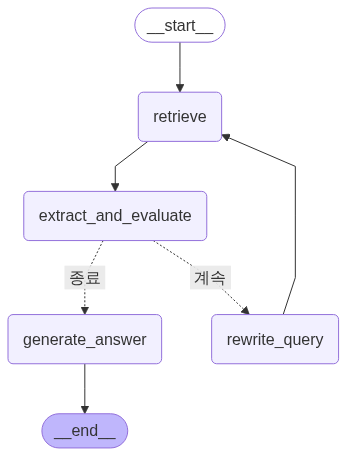

In [15]:
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display

# 그래프 생성
workflow = StateGraph(PersonalRagState)

# 노드 추가
workflow.add_node("retrieve", retrieve_documents)
workflow.add_node("extract_and_evaluate", extract_and_evaluate_information)
workflow.add_node("rewrite_query", rewrite_query)
workflow.add_node("generate_answer", generate_node_answer)


# 엣지 추가
workflow.add_edge(START, "retrieve")
workflow.add_edge("retrieve", "extract_and_evaluate")

# 조건부 엣지 추가
workflow.add_conditional_edges(
    "extract_and_evaluate",
    should_continue,
    {
        "계속": "rewrite_query",
        "종료": "generate_answer"
    }
)
workflow.add_edge("rewrite_query", "retrieve")
workflow.add_edge("generate_answer", END)

# 그래프 컴파일
personal_law_agent = workflow.compile()

# 그래프 시각화
display(Image(personal_law_agent.get_graph().draw_mermaid_png()))

In [16]:
inputs = {"question": "개인정보 처리에 대한 동의를 받을 때 주의해야 할 점은 무엇인가요?"}
for output in personal_law_agent.stream(inputs):
    for key, value in output.items():
        # 노드 출력
        pprint(f"Node '{key}':")
        pprint(f"Value: {value}", indent=2, width=80, depth=None)
    print("\n----------------------------------------------------------\n")

---문서 검색---
"Node 'retrieve':"
("Value: {'documents': [Document(id='1e977e79-209f-4f13-925e-1ccad809a820', "
 "metadata={'source': '../data/legal/개인정보 보호법(법률)(제19234호)(20240315).pdf', "
 "'chapter': '제3장 개인정보의 처리\\n         제1절 개인정보의 수집, 이용, 제공 등', 'name': '개인정보 "
 "보호법'}, page_content='[법률정보]\\n다음 조항은 개인정보 보호법 제3장 개인정보의 처리\\n         제1절 "
 '개인정보의 수집, 이용, 제공 등에서 발췌한 내용입니다.\\n\\n[법률조항]\\n제22조의2(아동의 개인정보 보호) ① 개인정보처리자는 '
 '만 14세 미만 아동의 개인정보를 처리하기 위하여 이 법에 따\\n른 동의를 받아야 할 때에는 그 법정대리인의 동의를 받아야 하며, '
 '법정대리인이 동의하였는지를 확인하여야 한다.\\n② 제1항에도 불구하고 법정대리인의 동의를 받기 위하여 필요한 최소한의 정보로서 '
 '대통령령으로 정하는 정보는\\n법정대리인의 동의 없이 해당 아동으로부터 직접 수집할 수 있다.\\n③ 개인정보처리자는 만 14세 미만의 '
 '아동에게 개인정보 처리와 관련한 사항의 고지 등을 할 때에는 이해하기 쉬운\\n양식과 명확하고 알기 쉬운 언어를 사용하여야 한다.\\n④ '
 '제1항부터 제3항까지에서 규정한 사항 외에 동의 및 동의 확인 방법 등에 필요한 사항은 대통령령으로 정한다.\\n[본조신설 2023. '
 "3. 14.]\\n \\n         제2절 개인정보의 처리 제한'), "
 "Document(id='87391978-847f-4bbe-87d9-d061cbbc1427', metadata={'source': "
 "'../data/legal/개인정보 보호법(법률)(제19234호)(20240315).pdf', 'chap

In [17]:
print(value['node_answer'])

# 개인정보 처리에 대한 동의를 받을 때 주의해야 할 점

## 1. 직접적인 답변
개인정보 처리에 대한 동의를 받을 때는 법정대리인의 동의를 받아야 하는 경우, 아동에게 이해하기 쉬운 언어로 고지해야 하며, 동의의 내용과 조건을 명확히 전달해야 합니다.

## 2. 관련 법률 조항 및 해석
- **법정대리인의 동의**: 만 14세 미만 아동의 개인정보를 처리하기 위해서는 법정대리인의 동의를 받아야 하며, 이를 확인해야 합니다 (출처: 법률정보).
- **고지의 의무**: 개인정보처리자는 아동에게 개인정보 처리와 관련한 사항을 이해하기 쉬운 양식과 명확한 언어로 고지해야 합니다 (출처: 법률정보).
- **동의 내용의 명시**: 동의를 받을 때는 제공받는 자, 이용 목적, 제공하는 개인정보 항목, 보유 및 이용 기간, 동의 거부 권리 및 불이익 내용을 알려야 합니다 (출처: [개인정보 보호법 제17조](https://law.go.kr/법령/개인정보보호법/제17조)).

## 3. 추가 설명 또는 예시
예를 들어, 아동의 개인정보를 수집하는 경우, 개인정보처리자는 아동에게 다음과 같은 정보를 제공해야 합니다:
- 개인정보를 제공받는 자의 이름
- 개인정보의 이용 목적 (예: 마케팅, 서비스 제공 등)
- 수집하는 개인정보 항목 (예: 이름, 연락처 등)
- 개인정보의 보유 및 이용 기간 (예: 3년)
- 동의 거부 시 불이익 내용 (예: 서비스 이용 제한)

이러한 정보는 아동이 이해할 수 있도록 간단하고 명확하게 전달되어야 합니다.

## 4. 결론 및 요약
개인정보 처리에 대한 동의를 받을 때는 법정대리인의 동의를 확인하고, 아동에게 이해하기 쉬운 방식으로 정보를 제공해야 합니다. 또한, 동의의 내용과 조건을 명확히 하여 정보주체가 자신의 권리를 충분히 이해할 수 있도록 해야 합니다. 이러한 절차를 준수함으로써 개인정보 보호법을 준수하고, 아동의 개인정보를 안전하게 처리할 수 있습니다.


`(2) 근로기준법 RAG 에이전트`

In [18]:
# 근로기준법
class LaborRagState(CorrectiveRagState):
    rewritten_query: str   # 재작성한 질문 
    extracted_info: Optional[ExtractedInformation]   # 추출된 정보 조각 
    node_answer: Optional[str]

In [19]:
from langchain_core.prompts import ChatPromptTemplate
from typing import Literal

def retrieve_documents(state: LaborRagState) -> LaborRagState:
    print("---문서 검색---")
    query = state.get("rewritten_query", state["question"])
    docs = labor_law_search.invoke(query)
    return {"documents": docs}

def extract_and_evaluate_information(state: LaborRagState) -> LaborRagState:
    print("---정보 추출 및 평가---")
    extracted_strips = []

    for doc in state["documents"]:
        extract_prompt = ChatPromptTemplate.from_messages([
            ("system", """당신은 근로기준법 전문가입니다. 주어진 문서에서 질문과 관련된 주요 사실과 정보를 3~5개 정도 추출하세요. 
            각 추출된 정보에 대해 다음 두 가지 측면을 0에서 1 사이의 점수로 평가하세요:
            1. 질문과의 관련성
            2. 답변의 충실성 (질문에 대한 완전하고 정확한 답변을 제공할 수 있는 정도)
            
            추출 형식:
            1. [추출된 정보]
            - 관련성 점수: [0-1 사이의 점수]
            - 충실성 점수: [0-1 사이의 점수]
            2. [추출된 정보]
            - 관련성 점수: [0-1 사이의 점수]
            - 충실성 점수: [0-1 사이의 점수]
            ...
            
            마지막으로, 추출된 정보를 종합하여 질문에 대한 전반적인 답변 가능성을 0에서 1 사이의 점수로 평가하세요."""),
            ("human", "[질문]\n{question}\n\n[문서 내용]\n{document_content}")
        ])

        extract_llm = llm.with_structured_output(ExtractedInformation)

        extracted_data = extract_llm.invoke(extract_prompt.format(
            question=state["question"],
            document_content=doc.page_content
        ))

        if extracted_data.query_relevance < 0.8:
            continue

        for strip in extracted_data.strips:
            if strip.relevance_score > 0.7 and strip.faithfulness_score > 0.7:
                extracted_strips.append(strip)

    return {
        "extracted_info": extracted_strips,
        "num_generations": state.get("num_generations", 0) + 1
    }

def rewrite_query(state: LaborRagState) -> LaborRagState:
    print("---쿼리 재작성---")

    rewrite_prompt = ChatPromptTemplate.from_messages([
        ("system", """당신은 근로기준법 전문가입니다. 주어진 원래 질문과 추출된 정보를 바탕으로, 더 관련성 있고 충실한 정보를 찾기 위해 검색 쿼리를 개선해주세요.

        다음 사항을 고려하여 검색 쿼리를 개선하세요:
        1. 원래 질문의 핵심 요소
        2. 추출된 정보의 관련성 점수
        3. 추출된 정보의 충실성 점수
        4. 부족한 정보나 더 자세히 알아야 할 부분

        개선된 검색 쿼리 작성 단계:
        1. 2-3개의 검색 쿼리를 제안하세요.
        2. 각 쿼리는 구체적이고 간결해야 합니다(5-10 단어 사이).
        3. 근로기준법과 관련된 전문 용어를 적절히 활용하세요.
        4. 각 쿼리 뒤에는 해당 쿼리를 제안한 이유를 간단히 설명하세요.

        출력 형식:
        1. [개선된 검색 쿼리 1]
        - 이유: [이 쿼리를 제안한 이유 설명]
        2. [개선된 검색 쿼리 2]
        - 이유: [이 쿼리를 제안한 이유 설명]
        3. [개선된 검색 쿼리 3]
        - 이유: [이 쿼리를 제안한 이유 설명]

        마지막으로, 제안된 쿼리 중 가장 효과적일 것 같은 쿼리를 선택하고 그 이유를 설명하세요."""),
        ("human", "원래 질문: {question}\n\n추출된 정보:\n{extracted_info}\n\n위 지침에 따라 개선된 검색 쿼리를 작성해주세요.")
    ])

    extracted_info_str = "\n".join([strip.content for strip in state["extracted_info"]])
    
    rewrite_llm = llm.with_structured_output(RefinedQuestion)

    response = rewrite_llm.invoke(rewrite_prompt.format(
        question=state["question"],
        extracted_info=extracted_info_str
    ))
    
    return {"rewritten_query": response.question_refined}

def generate_node_answer(state: LaborRagState) -> LaborRagState:
    print("---답변 생성---")

    answer_prompt = ChatPromptTemplate.from_messages([
        ("system", """당신은 근로기준법 전문가입니다. 주어진 질문과 추출된 정보를 바탕으로 답변을 생성해주세요. 
        답변은 마크다운 형식으로 작성하며, 각 정보의 출처를 명확히 표시해야 합니다. 
        답변 구조:
        1. 질문에 대한 직접적인 답변
        2. 관련 법률 조항 및 해석
        3. 추가 설명 또는 예시 (필요한 경우)
        4. 결론 및 요약
        각 섹션에서 사용된 정보의 출처를 괄호 안에 명시하세요. 예: (출처: 근로기준법 제15조)"""),
        ("human", "질문: {question}\n\n추출된 정보:\n{extracted_info}\n\n위 지침에 따라 최종 답변을 작성해주세요.")
    ])

    extracted_info_str = "\n".join([f"내용: {strip.content}\n출처: {strip.source}\n관련성: {strip.relevance_score}\n충실성: {strip.faithfulness_score}" for strip in state["extracted_info"]])

    node_answer = llm.invoke(answer_prompt.format(
        question=state["question"],
        extracted_info=extracted_info_str
    ))

    return {"node_answer": node_answer.content}

def should_continue(state: LaborRagState) -> Literal["계속", "종료"]:
    if state["num_generations"] >= 2:
        return "종료"
    if len(state["extracted_info"]) >= 1:
        return "종료"
    return "계속"

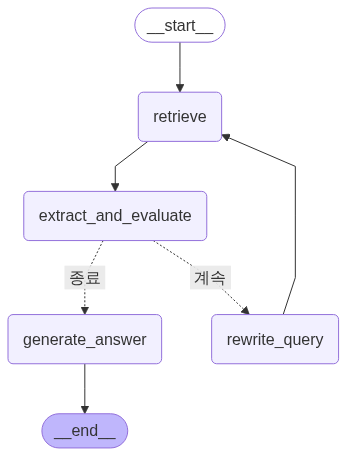

In [20]:
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display

# 그래프 생성
workflow = StateGraph(LaborRagState)

# 노드 추가
workflow.add_node("retrieve", retrieve_documents)
workflow.add_node("extract_and_evaluate", extract_and_evaluate_information)
workflow.add_node("rewrite_query", rewrite_query)
workflow.add_node("generate_answer", generate_node_answer)


# 엣지 추가
workflow.add_edge(START, "retrieve")
workflow.add_edge("retrieve", "extract_and_evaluate")

# 조건부 엣지 추가
workflow.add_conditional_edges(
    "extract_and_evaluate",
    should_continue,
    {
        "계속": "rewrite_query",
        "종료": "generate_answer"
    }
)
workflow.add_edge("rewrite_query", "retrieve")
workflow.add_edge("generate_answer", END)

# 그래프 컴파일
labor_law_agent = workflow.compile()

# 그래프 시각화
display(Image(labor_law_agent.get_graph().draw_mermaid_png()))

In [21]:
inputs = {"question": "근로계약 체결할 때 주의해야 할 점은 무엇인가요?"}
for output in labor_law_agent.stream(inputs):
    for key, value in output.items():
        # 노드 출력
        pprint(f"Node '{key}':")
        pprint(f"Value: {value}", indent=2, width=80, depth=None)
    print("\n----------------------------------------------------------\n")

---문서 검색---
"Node 'retrieve':"
("Value: {'documents': [Document(id='9c1e8b5f-5011-4629-bda9-8efb14ee4682', "
 "metadata={'source': '../data/legal/근로기준법(법률)(제18176호)(20211119).pdf', "
 "'chapter': '제5장 여성과 소년', 'name': '근로기준법'}, page_content='[법률정보]\\n다음 조항은 "
 '근로기준법 제5장 여성과 소년에서 발췌한 내용입니다.\\n\\n[법률조항]\\n제67조(근로계약) ① 친권자나 후견인은 미성년자의 '
 '근로계약을 대리할 수 없다.\\n② 친권자, 후견인 또는 고용노동부장관은 근로계약이 미성년자에게 불리하다고 인정하는 경우에는 이를 해지할 '
 '수\\n있다.<개정 2010. 6. 4.>\\n③ 사용자는 18세 미만인 사람과 근로계약을 체결하는 경우에는 제17조에 따른 근로조건을 '
 '서면(「전자문서 및 전\\n자거래 기본법」 제2조제1호에 따른 전자문서를 포함한다)으로 명시하여 교부하여야 한다.<신설 2007. 7. '
 "27., 2020.\\n5. 26., 2021. 1. 5.>'), "
 "Document(id='b2961447-3c5b-4c5a-9f0a-45bf6b777b5b', metadata={'source': "
 "'../data/legal/근로기준법(법률)(제18176호)(20211119).pdf', 'chapter': '제1장 총칙', "
 "'name': '근로기준법'}, page_content='[법률정보]\\n다음 조항은 근로기준법 제1장 총칙에서 발췌한 "
 '내용입니다.\\n\\n[법률조항]\\n제5조(근로조건의 준수) 근로자와 사용자는 각자가 단체협약, 취업규칙과 근로계약을 지키고 성실하게 '
 "이행할 의무가\\n있다.')]}")

--------------------------------------------------------

In [22]:
print(value['node_answer'])

# 근로계약 체결 시 주의해야 할 점

## 1. 직접적인 답변
근로계약을 체결할 때는 근로조건을 명확히 하고, 특히 미성년자와 계약을 체결할 경우 법적 요건을 준수해야 합니다. 또한, 계약의 이행에 대한 의무를 이해하고 있어야 합니다.

## 2. 관련 법률 조항 및 해석
- **미성년자 근로계약**: 사용자는 18세 미만인 사람과 계약을 체결할 경우, 근로조건을 서면으로 명시하여 교부해야 합니다. (출처: [근로기준법 제67조](https://law.go.kr/LSW/lsBylInfoP.do?bylSeq=1&bylNo=67))
- **대리 계약의 제한**: 미성년자의 근로계약은 친권자나 후견인이 대리할 수 없으며, 불리한 경우 해지할 수 있습니다. (출처: [근로기준법 제67조](https://law.go.kr/LSW/lsBylInfoP.do?bylSeq=1&bylNo=67))
- **고용노동부의 판단**: 고용노동부장관이 미성년자에게 불리하다고 판단할 경우 계약을 해지할 수 있습니다. (출처: [근로기준법 제67조](https://law.go.kr/LSW/lsBylInfoP.do?bylSeq=1&bylNo=67))
- **계약 이행 의무**: 근로자와 사용자는 각자가 단체협약, 취업규칙과 근로계약을 지키고 성실하게 이행할 의무가 있습니다. (출처: 법률정보)
- **근로조건의 명확성**: 근로계약 체결 시, 근로조건을 명확히 하고 이를 준수할 의무가 있다는 점을 유의해야 합니다. (출처: 법률정보)

## 3. 추가 설명 또는 예시
예를 들어, 만약 17세의 청소년이 아르바이트를 하기로 결정했다면, 사용자는 반드시 근로조건을 서면으로 제공해야 하며, 이 계약은 청소년의 친권자나 후견인이 대리할 수 없습니다. 만약 계약 내용이 청소년에게 불리하다면, 고용노동부는 해당 계약을 해지할 수 있습니다.

## 4. 결론 및 요약
근로계약 체결 시에는 근로조건을 명확히 하고, 미성년자와의 계약에 대한 법적 요건을 준수해야 합니다. 또한, 계약의 이행에 대한 의무를 

`(3) 주택임대차보호법 RAG 에이전트`

In [23]:
# 주택임대차보호법
class HousingRagState(CorrectiveRagState):
    rewritten_query: str   # 재작성한 질문 
    extracted_info: Optional[ExtractedInformation]   # 추출된 정보 조각 
    node_answer: Optional[str] 

In [24]:
from langchain_core.prompts import ChatPromptTemplate
from typing import Literal

def retrieve_documents(state: HousingRagState) -> HousingRagState:
    print("---문서 검색---")
    query = state.get("rewritten_query", state["question"])
    docs = housing_law_search.invoke(query)
    return {"documents": docs}

def extract_and_evaluate_information(state: HousingRagState) -> HousingRagState:
    print("---정보 추출 및 평가---")
    extracted_strips = []

    for doc in state["documents"]:
        extract_prompt = ChatPromptTemplate.from_messages([
            ("system", """당신은 주택임대차보호법 전문가입니다. 주어진 문서에서 질문과 관련된 주요 사실과 정보를 3~5개 정도 추출하세요. 
            각 추출된 정보에 대해 다음 두 가지 측면을 0에서 1 사이의 점수로 평가하세요:
            1. 질문과의 관련성
            2. 답변의 충실성 (질문에 대한 완전하고 정확한 답변을 제공할 수 있는 정도)
            
            추출 형식:
            1. [추출된 정보]
            - 관련성 점수: [0-1 사이의 점수]
            - 충실성 점수: [0-1 사이의 점수]
            2. [추출된 정보]
            - 관련성 점수: [0-1 사이의 점수]
            - 충실성 점수: [0-1 사이의 점수]
            ...
            
            마지막으로, 추출된 정보를 종합하여 질문에 대한 전반적인 답변 가능성을 0에서 1 사이의 점수로 평가하세요."""),
            ("human", "[질문]\n{question}\n\n[문서 내용]\n{document_content}")
        ])

        extract_llm = llm.with_structured_output(ExtractedInformation)

        extracted_data = extract_llm.invoke(extract_prompt.format(
            question=state["question"],
            document_content=doc.page_content
        ))

        if extracted_data.query_relevance < 0.8:
            continue

        for strip in extracted_data.strips:
            if strip.relevance_score > 0.7 and strip.faithfulness_score > 0.7:
                extracted_strips.append(strip)

    return {
        "extracted_info": extracted_strips,
        "num_generations": state.get("num_generations", 0) + 1
    }

def rewrite_query(state: HousingRagState) -> HousingRagState:
    print("---쿼리 재작성---")

    rewrite_prompt = ChatPromptTemplate.from_messages([
        ("system", """당신은 주택임대차보호법 전문가입니다. 주어진 원래 질문과 추출된 정보를 바탕으로, 더 관련성 있고 충실한 정보를 찾기 위해 검색 쿼리를 개선해주세요.

        다음 사항을 고려하여 검색 쿼리를 개선하세요:
        1. 원래 질문의 핵심 요소
        2. 추출된 정보의 관련성 점수
        3. 추출된 정보의 충실성 점수
        4. 부족한 정보나 더 자세히 알아야 할 부분

        개선된 검색 쿼리 작성 단계:
        1. 2-3개의 검색 쿼리를 제안하세요.
        2. 각 쿼리는 구체적이고 간결해야 합니다(5-10 단어 사이).
        3. 주택임대차보호법과 관련된 전문 용어를 적절히 활용하세요.
        4. 각 쿼리 뒤에는 해당 쿼리를 제안한 이유를 간단히 설명하세요.

        출력 형식:
        1. [개선된 검색 쿼리 1]
        - 이유: [이 쿼리를 제안한 이유 설명]
        2. [개선된 검색 쿼리 2]
        - 이유: [이 쿼리를 제안한 이유 설명]
        3. [개선된 검색 쿼리 3]
        - 이유: [이 쿼리를 제안한 이유 설명]

        마지막으로, 제안된 쿼리 중 가장 효과적일 것 같은 쿼리를 선택하고 그 이유를 설명하세요."""),
        ("human", "원래 질문: {question}\n\n추출된 정보:\n{extracted_info}\n\n위 지침에 따라 개선된 검색 쿼리를 작성해주세요.")
    ])

    extracted_info_str = "\n".join([strip.content for strip in state["extracted_info"]])
    
    rewrite_llm = llm.with_structured_output(RefinedQuestion)

    response = rewrite_llm.invoke(rewrite_prompt.format(
        question=state["question"],
        extracted_info=extracted_info_str
    ))
    
    return {"rewritten_query": response.question_refined}

def generate_node_answer(state: HousingRagState) -> HousingRagState:
    print("---답변 생성---")

    answer_prompt = ChatPromptTemplate.from_messages([
        ("system", """당신은 주택임대차보호법 전문가입니다. 주어진 질문과 추출된 정보를 바탕으로 답변을 생성해주세요. 
        답변은 마크다운 형식으로 작성하며, 각 정보의 출처를 명확히 표시해야 합니다. 
        답변 구조:
        1. 질문에 대한 직접적인 답변
        2. 관련 법률 조항 및 해석
        3. 추가 설명 또는 예시 (필요한 경우)
        4. 결론 및 요약
        각 섹션에서 사용된 정보의 출처를 괄호 안에 명시하세요. 예: (출처: 주택임대차보호법 제15조)"""),
        ("human", "질문: {question}\n\n추출된 정보:\n{extracted_info}\n\n위 지침에 따라 최종 답변을 작성해주세요.")
    ])

    extracted_info_str = "\n".join([f"내용: {strip.content}\n출처: {strip.source}\n관련성: {strip.relevance_score}\n충실성: {strip.faithfulness_score}" for strip in state["extracted_info"]])

    node_answer = llm.invoke(answer_prompt.format(
        question=state["question"],
        extracted_info=extracted_info_str
    ))

    return {"node_answer": node_answer.content}

def should_continue(state: HousingRagState) -> Literal["계속", "종료"]:
    if state["num_generations"] >= 2:
        return "종료"
    if len(state["extracted_info"]) >= 1:
        return "종료"
    return "계속"

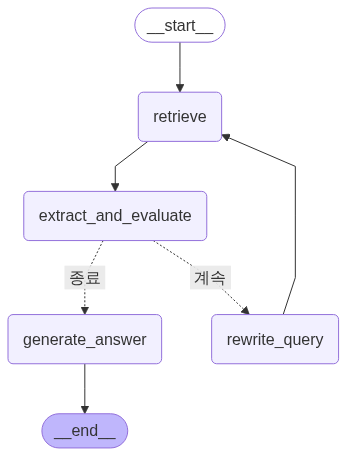

In [25]:
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display

# 그래프 생성
workflow = StateGraph(HousingRagState)

# 노드 추가
workflow.add_node("retrieve", retrieve_documents)
workflow.add_node("extract_and_evaluate", extract_and_evaluate_information)
workflow.add_node("rewrite_query", rewrite_query)
workflow.add_node("generate_answer", generate_node_answer)


# 엣지 추가
workflow.add_edge(START, "retrieve")
workflow.add_edge("retrieve", "extract_and_evaluate")

# 조건부 엣지 추가
workflow.add_conditional_edges(
    "extract_and_evaluate",
    should_continue,
    {
        "계속": "rewrite_query",
        "종료": "generate_answer"
    }
)
workflow.add_edge("rewrite_query", "retrieve")
workflow.add_edge("generate_answer", END)

# 그래프 컴파일
housing_law_agent = workflow.compile()

# 그래프 시각화
display(Image(housing_law_agent.get_graph().draw_mermaid_png()))

In [26]:
inputs = {"question": "대리인과 아파트 임대차 계약을 체결할 때 주의해야 할 점은 무엇인가요?"}
for output in housing_law_agent.stream(inputs):
    for key, value in output.items():
        # 노드 출력
        pprint(f"Node '{key}':")
        pprint(f"Value: {value}", indent=2, width=80, depth=None)
    print("\n----------------------------------------------------------\n")

---문서 검색---
"Node 'retrieve':"
("Value: {'documents': [Document(id='bfed1307-ee38-4927-ade9-ceac0556b69a', "
 "metadata={'source': '../data/legal/주택임대차보호법(법률)(제19356호)(20230719).pdf', "
 "'name': '주택임대차보호법'}, page_content='[법률정보]\\n다음 조항은 주택임대차보호법에서 발췌한 "
 '내용입니다.\\n\\n[법률조항]\\n제3조의7(임대인의 정보 제시 의무) 임대차계약을 체결할 때 임대인은 다음 각 호의 사항을 '
 '임차인에게 제시하여야 한\\n다.\\n1. 제3조의6제3항에 따른 해당 주택의 확정일자 부여일, 차임 및 보증금 등 정보. 다만, '
 '임대인이 임대차계약을 체결\\n하기 전에 제3조의6제4항에 따라 동의함으로써 이를 갈음할 수 있다.\\n2. 「국세징수법」 제108조에 '
 '따른 납세증명서 및 「지방세징수법」 제5조제2항에 따른 납세증명서. 다만, 임대인이 임\\n대차계약을 체결하기 전에 「국세징수법」 '
 '제109조제1항에 따른 미납국세와 체납액의 열람 및 「지방세징수법」 제\\n6조제1항에 따른 미납지방세의 열람에 각각 동의함으로써 이를 '
 "갈음할 수 있다.\\n[본조신설 2023. 4. 18.]'), "
 "Document(id='c9e6a39d-3bdc-4889-ac49-c21af20a3d98', metadata={'source': "
 "'../data/legal/주택임대차보호법(법률)(제19356호)(20230719).pdf', 'name': '주택임대차보호법'}, "
 "page_content='[법률정보]\\n다음 조항은 주택임대차보호법에서 발췌한 "
 '내용입니다.\\n\\n[법률조항]\\n제30조(주택임대차표준계약서 사용) 주택임대차계약을 서면으로 체결할 때에는 법무부장관이 '
 '국토교통부장관과 협의\\n하여 정하는 주택임대차표준계약서를 우선적

In [27]:
print(value['node_answer'])

# 대리인과 아파트 임대차 계약을 체결할 때 주의해야 할 점

## 1. 직접적인 답변
대리인을 통해 아파트 임대차 계약을 체결할 때는 대리인의 권한을 확인하고, 임대인의 정보 제공 의무를 준수하는 것이 중요합니다. 또한, 계약서의 모든 조항을 충분히 이해하고 검토해야 합니다.

## 2. 관련 법률 조항 및 해석
- **임대인의 정보 제공 의무**: 임대인은 임대차계약을 체결할 때 임차인에게 해당 주택의 확정일자 부여일, 차임 및 보증금 등의 정보를 제시해야 합니다 (출처: 법률정보).
- **대리인의 권한 확인**: 대리인을 통해 계약을 진행할 경우, 대리인의 권한과 임대인의 정보 제시 의무를 확인해야 합니다 (출처: 법률정보).
- **표준계약서 사용**: 주택임대차계약을 서면으로 체결할 때에는 법무부장관이 정하는 주택임대차표준계약서를 우선적으로 사용해야 하며, 당사자가 다른 서식을 사용하기로 합의한 경우에는 표준계약서를 사용하지 않아도 됩니다 (출처: 법률정보).

## 3. 추가 설명 또는 예시
계약서 체결 시, 대리인이 임대인을 대신하여 계약을 체결하는 경우, 대리인이 실제로 임대인의 권한을 위임받았는지 확인하는 것이 필수적입니다. 예를 들어, 대리인이 임대인의 서명 없이 계약을 체결할 경우, 그 계약은 무효가 될 수 있습니다. 또한, 계약서의 모든 조항을 충분히 이해하고 확인해야 하며, 임대차 계약의 조건을 명확히 하고 서명 전에 모든 내용을 검토하는 것이 중요합니다 (출처: 법률정보).

## 4. 결론 및 요약
대리인을 통해 아파트 임대차 계약을 체결할 때는 대리인의 권한을 확인하고, 임대인의 정보 제공 의무를 준수해야 합니다. 계약서의 모든 조항을 충분히 이해하고 검토하는 것이 중요하며, 표준계약서를 사용하는 것이 원칙입니다. 이러한 주의사항을 지키면 계약 체결 과정에서 발생할 수 있는 문제를 예방할 수 있습니다.


`(4) 웹 검색 기반 RAG 에이전트`

In [28]:
# 웹 검색 도구 
class SearchRagState(CorrectiveRagState):
    rewritten_query: str   # 재작성한 질문 
    extracted_info: Optional[ExtractedInformation]   # 추출된 정보 조각 
    node_answer: Optional[str] 

In [29]:
from langchain_core.prompts import ChatPromptTemplate
from typing import Literal

def retrieve_documents(state: SearchRagState) -> SearchRagState:
    print("---문서 검색---")
    query = state.get("rewritten_query", state["question"])
    docs = web_search.invoke(query)
    return {"documents": docs}

def extract_and_evaluate_information(state: SearchRagState) -> SearchRagState:
    print("---정보 추출 및 평가---")
    extracted_strips = []

    for doc in state["documents"]:
        extract_prompt = ChatPromptTemplate.from_messages([
            ("system", """당신은 인터넷 정보 검색 전문가입니다. 주어진 문서에서 질문과 관련된 주요 사실과 정보를 3~5개 정도 추출하세요. 
            각 추출된 정보에 대해 다음 두 가지 측면을 0에서 1 사이의 점수로 평가하세요:
            1. 질문과의 관련성
            2. 답변의 충실성 (질문에 대한 완전하고 정확한 답변을 제공할 수 있는 정도)
            
            추출 형식:
            1. [추출된 정보]
            - 관련성 점수: [0-1 사이의 점수]
            - 충실성 점수: [0-1 사이의 점수]
            2. [추출된 정보]
            - 관련성 점수: [0-1 사이의 점수]
            - 충실성 점수: [0-1 사이의 점수]
            ...
            
            마지막으로, 추출된 정보를 종합하여 질문에 대한 전반적인 답변 가능성을 0에서 1 사이의 점수로 평가하세요."""),
            ("human", "[질문]\n{question}\n\n[문서 내용]\n{document_content}")
        ])

        extract_llm = llm.with_structured_output(ExtractedInformation)

        extracted_data = extract_llm.invoke(extract_prompt.format(
            question=state["question"],
            document_content=doc.page_content
        ))

        if extracted_data.query_relevance < 0.8:
            continue

        for strip in extracted_data.strips:
            if strip.relevance_score > 0.7 and strip.faithfulness_score > 0.7:
                extracted_strips.append(strip)

    return {
        "extracted_info": extracted_strips,
        "num_generations": state.get("num_generations", 0) + 1
    }

def rewrite_query(state: SearchRagState) -> SearchRagState:
    print("---쿼리 재작성---")

    rewrite_prompt = ChatPromptTemplate.from_messages([
        ("system", """당신은 인터넷 정보 검색 전문가입니다. 주어진 원래 질문과 추출된 정보를 바탕으로, 더 관련성 있고 충실한 정보를 찾기 위해 검색 쿼리를 개선해주세요.

        다음 사항을 고려하여 검색 쿼리를 개선하세요:
        1. 원래 질문의 핵심 요소
        2. 추출된 정보의 관련성 점수
        3. 추출된 정보의 충실성 점수
        4. 부족한 정보나 더 자세히 알아야 할 부분

        개선된 검색 쿼리 작성 단계:
        1. 2-3개의 검색 쿼리를 제안하세요.
        2. 각 쿼리는 구체적이고 간결해야 합니다(5-10 단어 사이).
        3. 질문과 관련된 전문 용어를 적절히 활용하세요.
        4. 각 쿼리 뒤에는 해당 쿼리를 제안한 이유를 간단히 설명하세요.

        출력 형식:
        1. [개선된 검색 쿼리 1]
        - 이유: [이 쿼리를 제안한 이유 설명]
        2. [개선된 검색 쿼리 2]
        - 이유: [이 쿼리를 제안한 이유 설명]
        3. [개선된 검색 쿼리 3]
        - 이유: [이 쿼리를 제안한 이유 설명]

        마지막으로, 제안된 쿼리 중 가장 효과적일 것 같은 쿼리를 선택하고 그 이유를 설명하세요."""),
        ("human", "원래 질문: {question}\n\n추출된 정보:\n{extracted_info}\n\n위 지침에 따라 개선된 검색 쿼리를 작성해주세요.")
    ])

    extracted_info_str = "\n".join([strip.content for strip in state["extracted_info"]])
    
    rewrite_llm = llm.with_structured_output(RefinedQuestion)

    response = rewrite_llm.invoke(rewrite_prompt.format(
        question=state["question"],
        extracted_info=extracted_info_str
    ))
    
    return {"rewritten_query": response.question_refined}

def generate_node_answer(state: SearchRagState) -> SearchRagState:
    print("---답변 생성---")

    answer_prompt = ChatPromptTemplate.from_messages([
        ("system", """당신은 인터넷 정보 검색 전문가입니다. 주어진 질문과 추출된 정보를 바탕으로 답변을 생성해주세요. 
        답변은 마크다운 형식으로 작성하며, 각 정보의 출처를 명확히 표시해야 합니다. 
        답변 구조:
        1. 질문에 대한 직접적인 답변
        2. 관련 출처 및 링크
        3. 추가 설명 또는 예시 (필요한 경우)
        4. 결론 및 요약
        각 섹션에서 사용된 정보의 출처를 괄호 안에 명시하세요. 예: (출처: 블로그 (www.blog.com/page/001)"""),
        ("human", "질문: {question}\n\n추출된 정보:\n{extracted_info}\n\n위 지침에 따라 최종 답변을 작성해주세요.")
    ])

    extracted_info_str = "\n".join([f"내용: {strip.content}\n출처: {strip.source}\n관련성: {strip.relevance_score}\n충실성: {strip.faithfulness_score}" for strip in state["extracted_info"]])

    node_answer = llm.invoke(answer_prompt.format(
        question=state["question"],
        extracted_info=extracted_info_str
    ))

    return {"node_answer": node_answer.content}

def should_continue(state: SearchRagState) -> Literal["계속", "종료"]:
    if state["num_generations"] >= 2:
        return "종료"
    if len(state["extracted_info"]) >= 1:
        return "종료"
    return "계속"

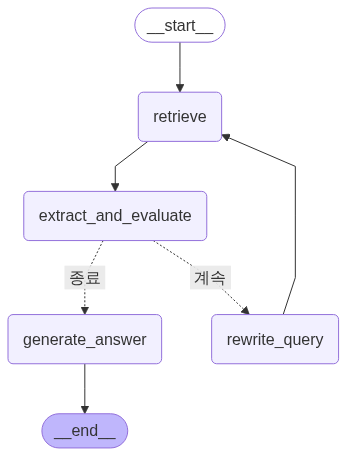

In [30]:
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display

# 그래프 생성
workflow = StateGraph(SearchRagState)

# 노드 추가
workflow.add_node("retrieve", retrieve_documents)
workflow.add_node("extract_and_evaluate", extract_and_evaluate_information)
workflow.add_node("rewrite_query", rewrite_query)
workflow.add_node("generate_answer", generate_node_answer)


# 엣지 추가
workflow.add_edge(START, "retrieve")
workflow.add_edge("retrieve", "extract_and_evaluate")

# 조건부 엣지 추가
workflow.add_conditional_edges(
    "extract_and_evaluate",
    should_continue,
    {
        "계속": "rewrite_query",
        "종료": "generate_answer"
    }
)
workflow.add_edge("rewrite_query", "retrieve")
workflow.add_edge("generate_answer", END)

# 그래프 컴파일
search_web_agent = workflow.compile()

# 그래프 시각화
display(Image(search_web_agent.get_graph().draw_mermaid_png()))

In [31]:
inputs = {"question": "대리인과 아파트 임대차 계약을 체결할 때 주의해야 할 점은 무엇인가요?"}
for output in search_web_agent.stream(inputs):
    for key, value in output.items():
        # 노드 출력
        pprint(f"Node '{key}':")
        pprint(f"Value: {value}", indent=2, width=80, depth=None)
    print("\n----------------------------------------------------------\n")

---문서 검색---
"Node 'retrieve':"
("Value: {'documents': [Document(metadata={'source': 'web search', 'url': "
 "'http://www.canews.kr/news/articleView.html?idxno=2383'}, "
 "page_content='<Document "
 'href="http://www.canews.kr/news/articleView.html?idxno=2383"/>\\n대리인과 체결하는 '
 '주택임대차 주의 사항 - 천안아산신문 Image 1: 천안아산신문 Image 2: 천안아산신문 대리인과 체결하는 주택임대차 주의 사항 '
 '대리인과 체결하는 주택임대차 주의 사항 천안아산신문 Image 3 최근 천안에서 대규모 임대차 분쟁이 발생했다. 임차인은 당연히 '
 '소유자로부터 위임받은 대리인과 체결한 계약이 당연히 적법 유효할 것이고 전세보증금도 주택의 가액 한도 내에서 보장될 것으로 생각한다. '
 '더구나 임대차 계약서 단서조항에 보증금 반환은 위임받은 업자가 책임진다고 기재해 임차인이 자칫 보증금을 반환받지 못할 위험을 초래했다. '
 'Image 4: 천안아산신문 천안시, 내년 10월 천안지역자활센터 신축 건립 Image 7: 천안시, 내년 10월 천안지역자활센터 신축 '
 '건립 Image 12: 천안아산신문 제호 : 천안아산신문 Copyright © 2025 천안아산신문. Image 13: '
 "ND소프트\\n</Document>'), Document(metadata={'source': 'web search', 'url': "
 "'https://m.blog.naver.com/porolya/223166836931'}, page_content='<Document "
 'href="https://m.blog.naver.com/porolya/223166836931"/>\\n대리인과 임대차 계약을 진행할 때 '
 '확인서류 및 유의사항 : 네이버 블로그 

In [32]:
print(value['node_answer'])

# 대리인과 아파트 임대차 계약을 체결할 때 주의해야 할 점

대리인과 아파트 임대차 계약을 체결할 때는 다음과 같은 점에 주의해야 합니다:

1. **대리인의 위임 확인**: 대리인이 소유자로부터 위임받았는지 확인해야 합니다. 위임장이 필요하며, 소유자의 인감도장이 찍혀 있어야 합니다. (출처: [CAnews](http://www.canews.kr/news/articleView.html?idxno=2383), [Naver Blog](https://blog.naver.com/porolya/223166836931))

2. **보증금 반환 책임 확인**: 임차인은 대리인과 계약을 체결할 때 보증금 반환에 대한 책임이 대리인에게 있다는 점을 명확히 확인해야 합니다. 계약서에 보증금 반환 조항이 포함되어 있는지 확인하는 것이 중요합니다. (출처: [CAnews](http://www.canews.kr/news/articleView.html?idxno=2383))

3. **계약서의 단서조항 확인**: 계약서에 보증금 반환 책임이 명시되어 있지 않으면 임차인이 보증금을 반환받지 못할 위험이 있습니다. (출처: [CAnews](http://www.canews.kr/news/articleView.html?idxno=2383))

4. **소유자 신분증 확인**: 대리인을 통한 계약 시 소유자의 신분증 또는 신분증 사본을 요구하는 것이 안전합니다. (출처: [Naver Blog](https://blog.naver.com/porolya/223166836931))

5. **전화 통화로 확인**: 계약 시 불안한 부분이 있다면 소유자와 전화 통화를 하여 계약 내용 및 대리 내용을 확인하는 것이 좋습니다. (출처: [Naver Blog](https://blog.naver.com/porolya/223166836931))

## 결론 및 요약

대리인과 아파트 임대차 계약을 체결할 때는 대리인의 위임 여부, 보증금 반환 책임, 계약서의 조항, 소유자의 신분증 확인, 그리고 소유자와의

### 4-2. 질문 라우팅 
- 사용자의 질문을 분석하여 적절한 에이전트를 선택 (Adaptive RAG 적용)

In [33]:
from typing import Annotated
from operator import add

# 메인 그래프 상태 정의
class ResearchAgentState(TypedDict):
    question: str
    answers: Annotated[List[str], add]
    final_answer: str
    datasources: List[str]
    evaluation_report: Optional[dict]
    user_decision: Optional[str]

In [34]:
from typing import Literal
from langchain_core.prompts import ChatPromptTemplate
from pydantic import BaseModel, Field

# 라우팅 결정을 위한 데이터 모델
class ToolSelector(BaseModel):
    """Routes the user question to the most appropriate tool."""
    tool: Literal["search_personal", "search_labor", "search_housing", "search_web"] = Field(
        description="Select one of the tools, based on the user's question.",
    )

class ToolSelectors(BaseModel):
    """Select the appropriate tools that are suitable for the user question."""
    tools: List[ToolSelector] = Field(
        description="Select one or more tools, based on the user's question.",
    )

# 구조화된 출력을 위한 LLM 설정
structured_llm_tool_selector = llm.with_structured_output(ToolSelectors)

# 라우팅을 위한 프롬프트 템플릿
system = dedent("""You are an AI assistant specializing in routing user questions to the appropriate tools.
Use the following guidelines:
- For questions specifically about legal provisions or articles of the privacy protection law (개인정보 보호법), use the search_personal tool.
- For questions specifically about legal provisions or articles of the labor law (근로기준법), use the search_labor tool.
- For questions specifically about legal provisions or articles of the housing law (주택임대차보호법), use the search_housing tool.
- For any other information, including questions related to these laws but not directly about specific legal provisions, or for the most up-to-date data, use the search_web tool.
Always choose all of the appropriate tools based on the user's question. 
If a question is about a law but doesn't seem to be asking about specific legal provisions, include both the relevant law search tool and the search_web tool.""")

route_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "{question}"),
    ]
)

# 질문 라우터 정의
question_tool_router = route_prompt | structured_llm_tool_selector

# 테스트 실행
print(question_tool_router.invoke({"question": "근로계약 체결할 때 개인정보 취급 상의 유의사항은 무엇인가요?"}))
print(question_tool_router.invoke({"question": "법에서 정한 연차휴가 기준을 알려주세요."}))
print(question_tool_router.invoke({"question": "개인정보보호법에서 정한 가명정보의 정의는 무엇인가요?"}))

tools=[ToolSelector(tool='search_personal'), ToolSelector(tool='search_labor'), ToolSelector(tool='search_web')]
tools=[ToolSelector(tool='search_labor'), ToolSelector(tool='search_web')]
tools=[ToolSelector(tool='search_personal'), ToolSelector(tool='search_web')]


In [35]:
# 질문 라우팅 노드 
def analyze_question_tool_search(state: ResearchAgentState):
    question = state["question"]
    result = question_tool_router.invoke({"question": question})
    datasources = [tool.tool for tool in result.tools]
    return {"datasources": datasources}


def route_datasources_tool_search(state: ResearchAgentState) -> List[str]:
    datasources = set(state['datasources'])
    valid_sources = {"search_personal", "search_labor", "search_housing", "search_web"}
    
    if datasources.issubset(valid_sources):
        return list(datasources)
    
    return list(valid_sources)

In [36]:
# 노드 정의 
def personal_rag_node(state: PersonalRagState, input=ResearchAgentState) -> ResearchAgentState:
    print("--- 개인정보보호법 전문가 에이전트 시작 ---")
    question = state["question"]
    answer = personal_law_agent.invoke({"question": question})
    return {"answers": [answer["node_answer"]]}

def labor_rag_node(state: LaborRagState, input=ResearchAgentState) -> ResearchAgentState:
    print("--- 근로기준법 전문가 에이전트 시작 ---")
    question = state["question"]
    answer = labor_law_agent.invoke({"question": question})
    return {"answers": [answer["node_answer"]]}

def housing_rag_node(state: HousingRagState, input=ResearchAgentState) -> ResearchAgentState:
    print("--- 주택임대차보호법 전문가 에이전트 시작 ---")
    question = state["question"]
    answer = housing_law_agent.invoke({"question": question})
    return {"answers": [answer["node_answer"]]}

def web_rag_node(state: SearchRagState, input=ResearchAgentState) -> ResearchAgentState:
    print("--- 인터넷 검색 전문가 에이전트 시작 ---")
    question = state["question"]
    answer = search_web_agent.invoke({"question": question})
    return {"answers": [answer["node_answer"]]}


In [37]:
# 최종 답변 생성 노드
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate

# RAG 프롬프트 정의
rag_prompt = ChatPromptTemplate.from_messages([
    ("system", """You are an assistant answering questions based on provided documents. Follow these guidelines:

1. Use only information from the given documents.
2. If the document lacks relevant info, say "제공된 정보로는 충분한 답변을 할 수 없습니다."
3. Cite the source of information for each sentence in your answer. Use the following format:
    - For legal articles: "법률명 제X조 Y항"
    - For web sources: "출처 제목 (URL)"
4. Don't speculate or add information not in the documents.
5. Keep answers concise and clear.
6. Omit irrelevant information.
7. If multiple sources provide the same information, cite all relevant sources.
8. If information comes from multiple sources, combine them coherently while citing each source.

Example of citation usage:
"부동산 거래 시 계약서에 거래 금액을 명시해야 합니다 (부동산 거래신고 등에 관한 법률 제3조 1항). 또한, 계약 체결일로부터 30일 이내에 신고해야 합니다 (부동산 거래 신고 안내 블로그, https://example.com/realestate)."
"""
    ),
    ("human", "Answer the following question using these documents:\n\n[Documents]\n{documents}\n\n[Question]\n{question}"),
])

def answer_final(state: ResearchAgentState) -> ResearchAgentState:
    """
    Generate answer using the retrieved_documents
    """
    print("---최종 답변---")
    question = state["question"]
    documents = state.get("answers", [])
    if not isinstance(documents, list):
        documents = [documents]

    # 문서 내용을 문자열로 결합 
    documents_text = "\n\n".join(documents)

    # RAG generation
    rag_chain = rag_prompt | llm | StrOutputParser()
    generation = rag_chain.invoke({"documents": documents_text, "question": question})
    return {"final_answer": generation, "question":question}


# LLM Fallback 프롬프트 정의
fallback_prompt = ChatPromptTemplate.from_messages([
    ("system", """You are an AI assistant helping with various topics. Follow these guidelines:

1. Provide accurate and helpful information to the best of your ability.
2. Express uncertainty when unsure; avoid speculation.
3. Keep answers concise yet informative.
4. Respond ethically and constructively.
5. Mention reliable general sources when applicable."""),
    ("human", "{question}"),
])

def llm_fallback(state: ResearchAgentState) -> ResearchAgentState:
    """
    Generate answer using the LLM without context
    """
    print("---Fallback 답변---")
    question = state["question"]
    
    # LLM chain
    llm_chain = fallback_prompt | llm | StrOutputParser()
    
    generation = llm_chain.invoke({"question": question})
    return {"final_answer": generation, "question":question}

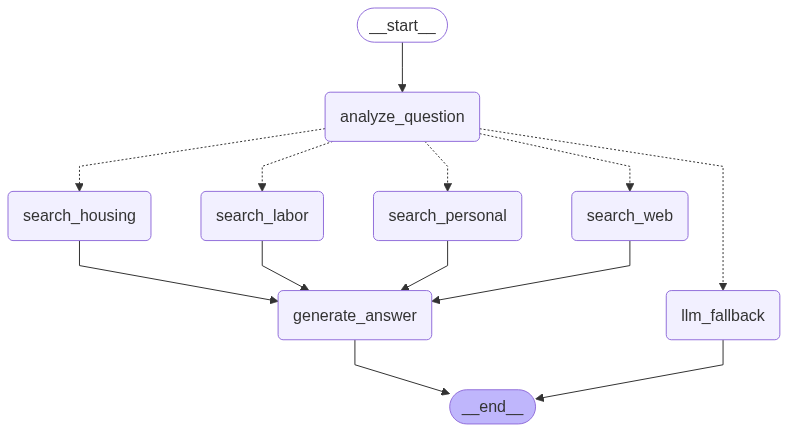

In [38]:
# 노드 정의를 딕셔너리로 관리
nodes = {
    "analyze_question": analyze_question_tool_search,
    "search_personal": personal_rag_node,
    "search_labor": labor_rag_node,
    "search_housing": housing_rag_node,
    "search_web": web_rag_node,
    "generate_answer": answer_final,
    "llm_fallback": llm_fallback
}

# 그래프 생성을 위한 StateGraph 객체를 정의
search_builder = StateGraph(ResearchAgentState)

# 노드 추가
for node_name, node_func in nodes.items():
    search_builder.add_node(node_name, node_func)

# 엣지 추가 (병렬 처리)
search_builder.add_edge(START, "analyze_question")
search_builder.add_conditional_edges(
    "analyze_question",
    route_datasources_tool_search,
    ["search_personal", "search_labor", "search_housing", "search_web", "llm_fallback"]
)

# 검색 노드들을 generate_answer에 연결
for node in ["search_personal", "search_labor", "search_housing", "search_web"]:
    search_builder.add_edge(node, "generate_answer")

search_builder.add_edge("generate_answer", END)
search_builder.add_edge("llm_fallback", END)

# 그래프 컴파일
rag_search_graph = search_builder.compile()

# 그래프 시각화 
display(Image(rag_search_graph.get_graph().draw_mermaid_png()))

In [39]:
inputs = {"question": "대리인과 아파트 임대차 계약을 체결할 때 주의해야 할 점은 무엇인가요?"}
for output in rag_search_graph.stream(inputs):
    for key, value in output.items():
        # 노드 출력
        pprint(f"Node '{key}':")
        pprint(f"Value: {value}", indent=2, width=80, depth=None)
    print("\n----------------------------------------------------------\n")

"Node 'analyze_question':"
"Value: {'datasources': ['search_housing', 'search_web']}"

----------------------------------------------------------

--- 주택임대차보호법 전문가 에이전트 시작 ---
---문서 검색---
--- 인터넷 검색 전문가 에이전트 시작 ---
---문서 검색---
---정보 추출 및 평가---
---답변 생성---
---정보 추출 및 평가---
"Node 'search_housing':"
("Value: {'answers': ['# 대리인과 아파트 임대차 계약을 체결할 때 주의해야 할 점\\n\\n## 1. 직접적인 "
 '답변\\n대리인과 아파트 임대차 계약을 체결할 때는 대리인의 권한을 확인하고, 계약서의 모든 조항을 충분히 이해하며, 임대인의 정보 제공 '
 '의무를 준수하는 것이 중요합니다.\\n\\n## 2. 관련 법률 조항 및 해석\\n- **임대인의 정보 제공 의무**: 임대인은 '
 '임대차계약을 체결할 때 임차인에게 해당 주택의 확정일자 부여일, 차임 및 보증금 등의 정보를 제시해야 합니다 (출처: 법률정보).\\n- '
 '**납세증명서 제시**: 임대인은 납세증명서를 임차인에게 제시해야 하며, 미납국세와 체납액의 열람에 동의함으로써 이를 갈음할 수 있습니다 '
 '(출처: 법률정보).\\n- **주택임대차표준계약서 사용**: 주택임대차계약을 서면으로 체결할 때에는 법무부장관이 정하는 '
 '주택임대차표준계약서를 우선적으로 사용해야 합니다 (출처: 주택임대차보호법 제30조).\\n\\n## 3. 추가 설명 또는 예시\\n- '
 '**대리인의 권한 확인**: 대리인과 계약을 체결할 때, 대리인의 권한을 확인하는 것이 중요합니다. 대리인이 임대인의 권한을 제대로 '
 '위임받았는지 확인해야 합니다 (출처: 주택임대차보호법 관련 일반 원칙).\\n- **계약서 이해**: 계약서의 모든 조항을 충분히 '
 '

In [40]:
print(value['final_answer'])

대리인과 아파트 임대차 계약을 체결할 때 주의해야 할 점은 다음과 같습니다:

1. **대리인의 권한 확인**: 대리인이 임대인의 권한을 제대로 위임받았는지 확인해야 합니다 (출처: 주택임대차보호법 관련 일반 원칙).

2. **계약서 이해**: 계약서의 모든 조항을 충분히 이해하고 확인해야 하며, 임대차 계약의 조건과 내용을 명확히 하는 것이 중요합니다 (출처: 주택임대차보호법 관련 일반 원칙).

3. **임대인의 정보 제공 의무 준수**: 임대인은 임차인에게 해당 주택의 확정일자 부여일, 차임 및 보증금 등의 정보를 제시해야 합니다 (출처: 법률정보).

4. **위임장 및 인감증명서 확인**: 대리인과 계약을 체결할 때, 위임장에는 소유자(임대인)의 인감도장이 반드시 찍혀 있어야 하며, 인감증명서를 통해 이를 확인해야 합니다 (출처: [Naver Blog](https://blog.naver.com/porolya/223166836931)).

5. **신분증 요구**: 대리인을 통한 계약 시 소유자(임대인)의 신분증 또는 신분증 사본을 요구하는 것이 안전합니다 (출처: [Naver Blog](https://blog.naver.com/porolya/223166836931)).

6. **보증금 반환 책임 명시**: 임대차 계약서에 보증금 반환에 대한 책임을 위임받은 대리인이 지겠다고 명시할 경우, 임차인은 보증금을 반환받지 못할 위험에 처할 수 있습니다 (출처: [CA News](http://www.canews.kr/news/articleView.html?idxno=2383)).

7. **소유자와의 확인**: 계약 시 불안한 부분이 있다면 소유자(임대인)와 전화 통화를 하여 계약 내용 및 대리 내용을 확인하는 것이 좋습니다 (출처: [Naver Blog](https://blog.naver.com/porolya/223166836931)).

이러한 점들을 주의하여 계약을 체결하면, 향후 발생할 수 있는 법적 분쟁을 예방할 수 있습니다.


## 5. 답변 평가 및 확인
### 5-1. 답변을 평가하는 ReAct 에이전트

In [41]:
from textwrap import dedent

evaluation_prompt = dedent("""
당신은 AI 어시스턴트가 생성한 답변을 평가하는 전문가입니다. 주어진 질문과 답변을 평가하고, 60점 만점으로 점수를 매기세요. 다음 기준을 사용하여 평가하십시오:

1. 정확성 (10점)
2. 관련성 (10점)
3. 완전성 (10점)
4. 인용 정확성 (10점)
5. 명확성과 간결성 (10점)
6. 객관성 (10점)

평가 과정:
1. 주어진 질문과 답변을 주의 깊게 읽으십시오.
2. 필요한 경우, 다음 도구를 사용하여 추가 정보를 수집하세요:
   - web_search: 웹 검색
   - personal_law_search: 개인정보보호법 검색
   - labor_law_search: 근로기준법 검색
   - housing_law_search: 주택임대차보호법 검색

   도구 사용 형식:
   Action: [tool_name]
   Action Input: [input for the tool]

3. 각 기준에 대해 1-10점 사이의 점수를 매기세요.
4. 총점을 계산하세요 (60점 만점).

출력 형식:
{
  "scores": {
    "accuracy": 0,
    "relevance": 0,
    "completeness": 0,
    "citation_accuracy": 0,
    "clarity_conciseness": 0,
    "objectivity": 0
  },
  "total_score": 0,
  "brief_evaluation": "간단한 평가 설명"
}

최종 출력에는 각 기준의 점수, 총점, 그리고 간단한 평가 설명만 포함하세요.
""")

In [42]:
tools

[StructuredTool(name='personal_law_search', description='개인정보보호법 법률 조항을 검색합니다.', args_schema=<class 'langchain_core.utils.pydantic.personal_law_search'>, func=<function personal_law_search at 0x0000024885A52AC0>),
 StructuredTool(name='labor_law_search', description='근로기준법 법률 조항을 검색합니다.', args_schema=<class 'langchain_core.utils.pydantic.labor_law_search'>, func=<function labor_law_search at 0x00000248F509B880>),
 StructuredTool(name='housing_law_search', description='주택임대차보호법 법률 조항을 검색합니다.', args_schema=<class 'langchain_core.utils.pydantic.housing_law_search'>, func=<function housing_law_search at 0x0000024885A52A20>),
 StructuredTool(name='web_search', description='데이터베이스에 없는 정보 또는 최신 정보를 웹에서 검색합니다.', args_schema=<class 'langchain_core.utils.pydantic.web_search'>, func=<function web_search at 0x00000248862479C0>)]

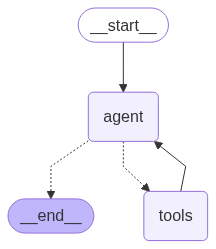

In [43]:
from langgraph.prebuilt import create_react_agent
from IPython.display import Image, display

# 그래프 생성 
answer_reviewer = create_react_agent(
    llm, 
    tools=tools, 
    #state_modifier=evaluation_prompt,
    )

answer_reviewer = create_react_agent(llm, tools)

# 그래프 출력
display(Image(answer_reviewer.get_graph().draw_mermaid_png()))

In [44]:
# 그래프 실행
from langchain_core.messages import HumanMessage

# messages = [HumanMessage(content=f"""[질문]\n\{value['question']}n\n[답변]\n{value['final_answer']}""")]
# messages = answer_reviewer.invoke({"messages": messages})
# for m in messages['messages']:
#     m.pretty_print()

# 프롬프트와 내용을 하나의 메시지로 결합
combined_content = f"""{evaluation_prompt}

[질문]
{value['question']}

[답변]
{value['final_answer']}"""

messages = [HumanMessage(content=combined_content)]
result = answer_reviewer.invoke({"messages": messages})

for m in result['messages']:
    m.pretty_print()

================================ Human Message =================================


당신은 AI 어시스턴트가 생성한 답변을 평가하는 전문가입니다. 주어진 질문과 답변을 평가하고, 60점 만점으로 점수를 매기세요. 다음 기준을 사용하여 평가하십시오:

1. 정확성 (10점)
2. 관련성 (10점)
3. 완전성 (10점)
4. 인용 정확성 (10점)
5. 명확성과 간결성 (10점)
6. 객관성 (10점)

평가 과정:
1. 주어진 질문과 답변을 주의 깊게 읽으십시오.
2. 필요한 경우, 다음 도구를 사용하여 추가 정보를 수집하세요:
   - web_search: 웹 검색
   - personal_law_search: 개인정보보호법 검색
   - labor_law_search: 근로기준법 검색
   - housing_law_search: 주택임대차보호법 검색

   도구 사용 형식:
   Action: [tool_name]
   Action Input: [input for the tool]

3. 각 기준에 대해 1-10점 사이의 점수를 매기세요.
4. 총점을 계산하세요 (60점 만점).

출력 형식:
{
  "scores": {
    "accuracy": 0,
    "relevance": 0,
    "completeness": 0,
    "citation_accuracy": 0,
    "clarity_conciseness": 0,
    "objectivity": 0
  },
  "total_score": 0,
  "brief_evaluation": "간단한 평가 설명"
}

최종 출력에는 각 기준의 점수, 총점, 그리고 간단한 평가 설명만 포함하세요.


[질문]
대리인과 아파트 임대차 계약을 체결할 때 주의해야 할 점은 무엇인가요?

[답변]
대리인과 아파트 임대차 계약을 체결할 때 주의해야 할 점은 다음과 같습니다:

1. **대리인의 권한 확인**: 대리인이 임대인의 권한을 제대로 위

In [45]:
json.loads(m.content).keys()

dict_keys(['scores', 'total_score', 'brief_evaluation'])

In [46]:
print(json.loads(m.content)['total_score'])

56


### 5-2. 답변 평가 내용을 확인하는 HITL 추가

In [47]:
# 1. JSON 파싱 오류를 처리하는 안전한 함수
import json
import re
from langchain_core.messages import HumanMessage

def safe_json_parse(text):
    """
    AI 응답에서 JSON을 안전하게 추출하는 함수
    """
    try:
        # 1) 직접 JSON 파싱 시도
        return json.loads(text)
    except json.JSONDecodeError:
        try:
            # 2) JSON 블록 찾기 (```json ... ``` 형태)
            json_match = re.search(r'```json\s*(.*?)\s*```', text, re.DOTALL)
            if json_match:
                return json.loads(json_match.group(1))
            
            # 3) { ... } 패턴 찾기
            brace_match = re.search(r'\{.*\}', text, re.DOTALL)
            if brace_match:
                return json.loads(brace_match.group(0))
            
            # 4) 파싱 실패시 기본 구조 반환
            return {
                "accuracy": "파싱 실패",
                "completeness": "파싱 실패", 
                "relevance": "파싱 실패",
                "clarity": "파싱 실패",
                "legal_accuracy": "파싱 실패",
                "overall_score": 0,
                "comments": f"JSON 파싱 실패. 원본 응답: {text[:200]}..."
            }
        except Exception as e:
            return {
                "accuracy": "오류",
                "completeness": "오류",
                "relevance": "오류", 
                "clarity": "오류",
                "legal_accuracy": "오류",
                "overall_score": 0,
                "comments": f"파싱 오류: {str(e)}"
            }

# 2. 개선된 evaluation_prompt (JSON 형식 강조)
evaluation_prompt_improved = """
당신은 법률 상담 답변의 품질을 평가하는 전문가입니다.

다음 기준으로 답변을 평가해주세요:
1. 정확성 (Accuracy): 법률 정보의 정확성
2. 완전성 (Completeness): 질문에 대한 포괄적 답변
3. 관련성 (Relevance): 질문과의 연관성
4. 명확성 (Clarity): 이해하기 쉬운 설명
5. 법적 정확성 (Legal Accuracy): 법조문 인용의 정확성

**중요: 반드시 아래 JSON 형식으로만 응답해주세요:**

```json
{
    "accuracy": "우수/좋음/보통/부족",
    "completeness": "우수/좋음/보통/부족",
    "relevance": "우수/좋음/보통/부족", 
    "clarity": "우수/좋음/보통/부족",
    "legal_accuracy": "우수/좋음/보통/부족",
    "overall_score": 85,
    "comments": "구체적인 평가 의견"
}
```

JSON 형식을 반드시 지켜주세요. 다른 텍스트는 포함하지 마세요.
"""


In [48]:
# 답변 평가하는 노드를 추가
def evaluate_answer_node(state:ResearchAgentState):
    question = state["question"]
    final_answer = state["final_answer"]

    messages = [HumanMessage(content=f"""[질문]\n\{question}n\n[답변]\n{final_answer}""")]
    response = answer_reviewer.invoke({"messages": messages})
    response_content = response['messages'][-1].content

    #response_dict = json.loads(response['messages'][-1].content)
    response_dict = safe_json_parse(response_content)

    return {"evaluation_report": response_dict, "question": question, "final_answer": final_answer}

# HITL 조건부 엣지 정의
def human_review(state: ResearchAgentState):
    print("\n현재 답변:")
    print(state['final_answer'])
    print("\n평가 결과:")
    
    evaluation_report = state['evaluation_report']
    score = evaluation_report.get('overall_score') or evaluation_report.get('total_score', 0)
    print(f"총점: {score}/100")    
    #print(f"총점: {state['evaluation_report']['total_score']}/60")
    #print(state['evaluation_report']['brief_evaluation'])
    print(f"간단 평가: {state['evaluation_report'].get('brief_evaluation', state['evaluation_report'].get('comments', '정보 없음'))}")
    
    user_input = input("\n이 답변을 승인하시겠습니까? (y/n): ").lower()
    
    if user_input == 'y':
        return "approved"
    else:
        return "rejected"

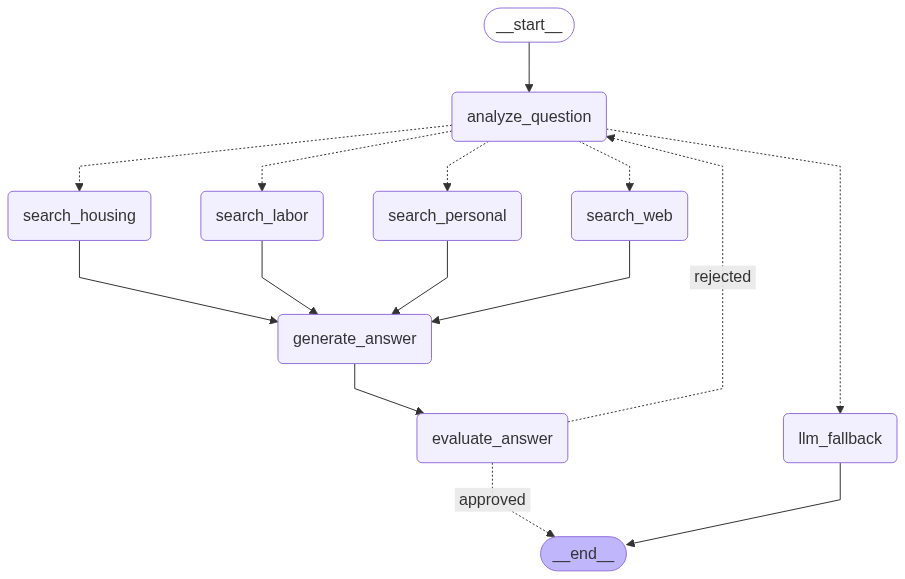

In [49]:
# 노드 정의를 딕셔너리로 관리
nodes = {
    "analyze_question": analyze_question_tool_search,
    "search_personal": personal_rag_node,
    "search_labor": labor_rag_node,
    "search_housing": housing_rag_node,
    "search_web": web_rag_node,
    "generate_answer": answer_final,
    "llm_fallback": llm_fallback,
    "evaluate_answer": evaluate_answer_node, 
}

# 그래프 생성을 위한 StateGraph 객체를 정의
search_builder = StateGraph(ResearchAgentState)

# 노드 추가
for node_name, node_func in nodes.items():
    search_builder.add_node(node_name, node_func)

# 엣지 추가 (병렬 처리)
search_builder.add_edge(START, "analyze_question")
search_builder.add_conditional_edges(
    "analyze_question",
    route_datasources_tool_search,
    ["search_personal", "search_labor", "search_housing", "search_web", "llm_fallback"]
)

# 검색 노드들을 generate_answer에 연결
for node in ["search_personal", "search_labor", "search_housing", "search_web"]:
    search_builder.add_edge(node, "generate_answer")

search_builder.add_edge("generate_answer", "evaluate_answer")

# HITL 결과에 따른 조건부 엣지 추가
search_builder.add_conditional_edges(
    "evaluate_answer",
    human_review,
    {
        "approved": END,
        "rejected": "analyze_question"  # 승인되지 않은 경우 질문 분석 단계로 돌아감
    }
)

search_builder.add_edge("llm_fallback", END)

# 그래프 컴파일
legal_rag_agent = search_builder.compile()

# 그래프 시각화 
display(Image(legal_rag_agent.get_graph().draw_mermaid_png()))

In [50]:
inputs = {"question": "대리인과 아파트 임대차 계약을 체결할 때 주의해야 할 점은 무엇인가요?"}
for output in legal_rag_agent.stream(inputs):
    for key, value in output.items():
        # 노드 출력
        pprint(f"Node '{key}':")
        pprint(f"Value: {value}", indent=2, width=80, depth=None)
    print("\n----------------------------------------------------------\n")

"Node 'analyze_question':"
"Value: {'datasources': ['search_housing', 'search_web']}"

----------------------------------------------------------

--- 주택임대차보호법 전문가 에이전트 시작 ---
---문서 검색---
--- 인터넷 검색 전문가 에이전트 시작 ---
---문서 검색---
---정보 추출 및 평가---
---답변 생성---
---정보 추출 및 평가---
"Node 'search_housing':"
("Value: {'answers': ['# 대리인과 아파트 임대차 계약을 체결할 때 주의해야 할 점\\n\\n## 1. 직접적인 "
 '답변\\n대리인과 아파트 임대차 계약을 체결할 때는 임대인의 정보 제공 의무와 계약서 작성의 중요성을 주의해야 합니다. 특히, 임대인은 '
 '임차인에게 주택의 확정일자 부여일, 차임 및 보증금 등의 정보를 명확히 제시해야 하며, 계약서는 법무부장관이 정한 표준계약서를 사용하는 '
 '것이 바람직합니다.\\n\\n## 2. 관련 법률 조항 및 해석\\n- **정보 제공 의무**: 임대인은 임차인에게 해당 주택의 확정일자 '
 '부여일, 차임 및 보증금 등의 정보를 제시해야 합니다 (출처: 법률정보).\\n- **납세증명서 제시**: 임대인은 납세증명서를 '
 '임차인에게 제시해야 하며, 미납국세와 체납액의 열람에 동의함으로써 이를 갈음할 수 있습니다 (출처: 법률정보).\\n- **계약서 '
 '작성**: 주택임대차계약을 서면으로 체결할 때에는 법무부장관이 정하는 주택임대차표준계약서를 우선적으로 사용해야 하며 (출처: 법률정보), '
 '당사자가 다른 서식을 사용하기로 합의한 경우에는 표준계약서를 사용하지 않아도 됩니다 (출처: 법률정보).\\n- **계약 조건 '
 '명확화**: 임대차 계약의 조건을 명확히 하고, 서면으로 기록하는 것이 필요합니다 (출처: 법률정보).\\n\\n## 3. 추가 설명 

In [51]:
print(value)

{'evaluation_report': {'accuracy': '파싱 실패', 'completeness': '파싱 실패', 'relevance': '파싱 실패', 'clarity': '파싱 실패', 'legal_accuracy': '파싱 실패', 'overall_score': 0, 'comments': 'JSON 파싱 실패. 원본 응답: 대리인과 아파트 임대차 계약을 체결할 때 주의해야 할 점은 다음과 같습니다:\n\n1. **위임장 확인**: 대리인과 계약을 체결할 때, 위임장에는 소유자(임대인)의 인감도장이 반드시 찍혀 있어야 하며, 위임한 내용과 계약 내용이 일치하는지 확인해야 합니다.\n\n2. **인감증명서 확인**: 계약 현장에서 대리인이 가져온 위임장에 소유자(임대인)의 인감도장이 찍...'}, 'question': '대리인과 아파트 임대차 계약을 체결할 때 주의해야 할 점은 무엇인가요?', 'final_answer': '대리인과 아파트 임대차 계약을 체결할 때 주의해야 할 점은 다음과 같습니다:\n\n1. **위임장 확인**: 대리인과 계약을 체결할 때, 위임장에는 소유자(임대인)의 인감도장이 반드시 찍혀 있어야 하며, 위임한 내용과 계약 내용이 일치하는지 확인해야 합니다 (출처: [네이버 블로그](https://blog.naver.com/porolya/223166836931)).\n\n2. **인감증명서 확인**: 계약 현장에서 대리인이 가져온 위임장에 소유자(임대인)의 인감도장이 찍혀 있는지와 그 도장을 증명하는 인감증명서를 확인하는 것이 중요합니다 (출처: [네이버 블로그](https://blog.naver.com/porolya/223166836931)).\n\n3. **신분증 요구**: 대리인을 통한 계약 시 소유자(임대인)의 신분증 또는 신분증 사본을 요구하는 것이 안전합니다 (출처: [네이버 블로그](https://blog.naver.com/porolya/223166836931)).\n\n4. **보증금 반환 책임 명시**: 임대차 계

In [52]:
inputs = {"question": "개인정보 유출 시 기업이 취해야 할 법적 조치는 무엇인가요?"}
for output in legal_rag_agent.stream(inputs):
    for key, value in output.items():
        # 노드 출력
        pprint(f"Node '{key}':")
        pprint(f"Value: {value}", indent=2, width=80, depth=None)
    print("\n----------------------------------------------------------\n")

"Node 'analyze_question':"
"Value: {'datasources': ['search_personal', 'search_web']}"

----------------------------------------------------------

--- 개인정보보호법 전문가 에이전트 시작 ---
---문서 검색---
--- 인터넷 검색 전문가 에이전트 시작 ---
---문서 검색---
---정보 추출 및 평가---
---정보 추출 및 평가---
---답변 생성---
---답변 생성---
"Node 'search_personal':"
("Value: {'answers': ['# 개인정보 유출 시 기업이 취해야 할 법적 조치\\n\\n## 1. 직접적인 답변\\n개인정보 "
 '유출 시 기업은 유출 사실을 신속하게 알리고, 피해를 최소화하기 위한 조치를 취해야 합니다. 또한, 유출된 개인정보의 항목, 유출 시점 '
 '및 경위, 대응 조치 등을 정보주체에게 통지해야 합니다.\\n\\n## 2. 관련 법률 조항 및 해석\\n- **개인정보 보호법 '
 '제29조**: 개인정보의 안전한 관리에 대한 의무를 규정하고 있습니다. 개인정보처리자는 기술적, 관리적, 물리적 조치를 통해 개인정보의 '
 '안전성을 확보해야 합니다 (출처: 개인정보 보호법 제29조).\\n- **개인정보 보호법 제34조**: 개인정보 유출 시, '
 '개인정보처리자는 지체 없이 정보주체에게 유출된 개인정보의 항목, 유출 시점과 경위, 피해 최소화 방법, 대응조치 및 피해 구제절차를 '
 '알려야 합니다 (출처: 개인정보 보호법 제34조).\\n- **유출 통지 및 신고**: 유출 사실을 알게 되었을 때, 유출의 유형, 경로 '
 '및 규모를 고려하여 보호위원회 또는 전문기관에 신고해야 하며, 이와 관련된 절차는 대통령령으로 정해집니다 (출처: 개인정보 보호법 관련 '
 '법률정보).\\n\\n## 3. 추가 설명 또는 예시\\n예를 들어, 기업이 고객의 개인정보가 유출된 사실을

In [53]:
print(value)

{'evaluation_report': {'accuracy': '파싱 실패', 'completeness': '파싱 실패', 'relevance': '파싱 실패', 'clarity': '파싱 실패', 'legal_accuracy': '파싱 실패', 'overall_score': 0, 'comments': 'JSON 파싱 실패. 원본 응답: 개인정보 유출 시 기업이 취해야 할 법적 조치는 다음과 같습니다:\n\n1. **신속한 통지**: 기업은 개인정보 유출 사실을 알게 되었을 때, 지체 없이 해당 정보주체에게 유출된 개인정보의 항목, 유출 시점과 경위, 피해 최소화 방법 등을 통지해야 합니다. 이는 개인정보 보호법 제34조에 명시되어 있습니다.\n\n2. **피해 최소화 조치**: 유출된 개인정보로...'}, 'question': '개인정보 유출 시 기업이 취해야 할 법적 조치는 무엇인가요?', 'final_answer': '개인정보 유출 시 기업이 취해야 할 법적 조치는 다음과 같습니다:\n\n1. **신속한 통지**: 기업은 개인정보 유출 사실을 고객들에게 즉시 알리는 의무가 있습니다 (출처: [블로그](https://blog.naver.com/minwhoip_1/223589746020?viewType=pc)). 이는 개인정보 보호법 제34조에 명시된 사항입니다 (출처: 개인정보 보호법 제34조).\n\n2. **복구 조치 마련**: 유출된 개인정보를 복구하기 위한 구체적인 조치를 마련해야 합니다 (출처: [블로그](https://blog.naver.com/minwhoip_1/223589746020?viewType=pc)).\n\n3. **즉각적인 대응**: 기업은 개인정보 유출 발생 시 즉각적인 대응 조치를 취해야 하며, 이는 법적으로 요구되는 규정입니다 (출처: [Tistory](https://31aowazo.tistory.com/entry/%EA%B0%9C%EC%9D%B8%EC%A0%95%EB%B3%B4-%EC%9C%A0%EC%B6%9C-%EC%8B%9

## 6. Gradio 챗봇

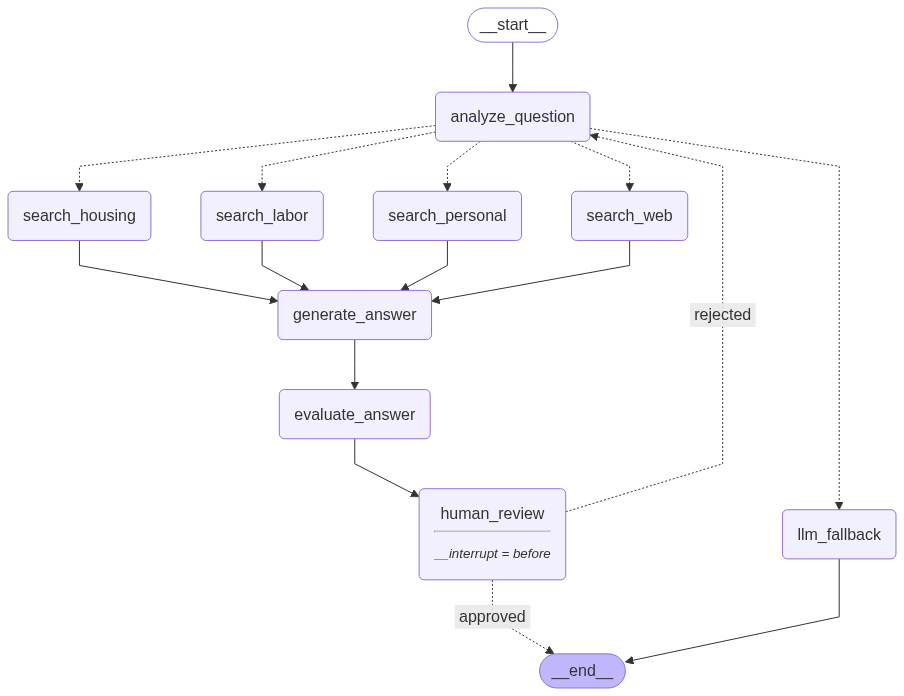

In [54]:
from langgraph.checkpoint.memory import MemorySaver

# HITL 노드로 변경 (그라디오에서 입력을 처리)
def human_review(state: ResearchAgentState):
    pass

# 그래프 생성을 위한 StateGraph 객체를 정의
search_builder = StateGraph(ResearchAgentState)

# 노드 추가
nodes = {
    "analyze_question": analyze_question_tool_search,
    "search_personal": personal_rag_node,
    "search_labor": labor_rag_node,
    "search_housing": housing_rag_node,
    "search_web": web_rag_node,
    "generate_answer": answer_final,
    "llm_fallback": llm_fallback,
    "evaluate_answer": evaluate_answer_node, 
    "human_review": human_review,
}

for node_name, node_func in nodes.items():
    search_builder.add_node(node_name, node_func)

# 엣지 추가 (병렬 처리)
search_builder.add_edge(START, "analyze_question")
search_builder.add_conditional_edges(
    "analyze_question",
    route_datasources_tool_search,
    ["search_personal", "search_labor", "search_housing", "search_web", "llm_fallback"]
)

# 검색 노드들을 generate_answer에 연결
for node in ["search_personal", "search_labor", "search_housing", "search_web"]:
    search_builder.add_edge(node, "generate_answer")

search_builder.add_edge("generate_answer", "evaluate_answer")
search_builder.add_edge("evaluate_answer", "human_review")

# HITL 결과에 따른 조건부 엣지 추가
search_builder.add_conditional_edges(
    "human_review",
    lambda x: "approved" if x.get("user_decision") == "approved" else "rejected",
    {
        "approved": END,
        "rejected": "analyze_question"
    }
)

search_builder.add_edge("llm_fallback", END)

# 메모리 추가
memory = MemorySaver()

# 그래프 컴파일 (Breakpoint 설정)
legal_rag_agent = search_builder.compile(checkpointer=memory, interrupt_before=["human_review"])

# 그래프 시각화 
display(Image(legal_rag_agent.get_graph().draw_mermaid_png()))

In [55]:
import gradio as gr
import uuid
from typing import List, Tuple
from langgraph.checkpoint.memory import MemorySaver

# 메모리 사용 준비
memory = MemorySaver()
legal_rag_agent = search_builder.compile(checkpointer=memory, interrupt_before=["human_review"])

# 예시 질문들
example_questions = [
    "사업장에서 CCTV를 설치할 때 주의해야 할 법적 사항은 무엇인가요?",
    "전월세 계약 갱신 요구권의 행사 기간과 조건은 어떻게 되나요?",
    "개인정보 유출 시 기업이 취해야 할 법적 조치는 무엇인가요?",
]

# 챗봇 클래스 생성
class ChatBot:
    def __init__(self):
        self.thread_id = str(uuid.uuid4())
        self.user_decision = False

    def process_message(self, message: str) -> str:
        try:
            config = {"configurable": {"thread_id": self.thread_id}}
            
            if not self.user_decision:
                # Breakpoint 까지 먼저 실행
                inputs = {"question": message}
                legal_rag_agent.invoke(inputs, config=config)

                # Breakpoint에서 현재 상태를 출력하고, 사용자의 승인 여부를 입력받음 
                current_state = legal_rag_agent.get_state(config)
                print("Current state:", current_state)
                
                final_answer = current_state.values.get("final_answer", "No answer available")
                evaluation_report = current_state.values.get('evaluation_report', {'total_score': 0, 'brief_evaluation': 'No evaluation available'})
                
                response = f"""현재 답변:
            {final_answer}

            평가 결과:
            총점: {evaluation_report.get('total_score', 0)}/60
            {evaluation_report.get('brief_evaluation', 'No evaluation available')}

            이 답변을 승인하시겠습니까? (y/n): """
                
                # 사용자 승인 여부를 True로 변경 
                self.user_decision = True
                return response
                
            else:
                # 사용자 입력에 따라 다음 경로를 선택
                user_decision = message.lower()
                if user_decision == 'y':
                    self.user_decision = False # 초기화 
                    # 상태 업데이트 - 질문을 수정하여 업데이트
                    legal_rag_agent.update_state(config, {"user_decision": "approved"})
                    # 나머지 작업을 이어서 진행 
                    legal_rag_agent.invoke(None, config=config)
                    # 작업이 종료되고 최종 상태의 메시지를 출력 
                    current_state = legal_rag_agent.get_state(config)
                    print("Final state:", current_state)
                    return current_state.values.get("final_answer", "No final answer available")
                else:
                    self.user_decision = False # 초기화 
                    # 상태 업데이트 - 질문을 수정하여 업데이트
                    legal_rag_agent.update_state(config, {"user_decision": "rejected"})
                    # 나머지 작업을 이어서 진행 
                    legal_rag_agent.invoke(None, config=config)
                    # Breakpoint에서 현재 상태를 출력하고, 사용자의 승인 여부를 입력받음 
                    current_state = legal_rag_agent.get_state(config)
                    print("Revised state:", current_state)
                    
                    final_answer = current_state.values.get("final_answer", "No answer available")
                    evaluation_report = current_state.values.get('evaluation_report', {'total_score': 0, 'brief_evaluation': 'No evaluation available'})
                    
                    response = f"""다시 생성한 답변:
                {final_answer}

                평가 결과:
                총점: {evaluation_report.get('total_score', 0)}/60
                {evaluation_report.get('brief_evaluation', 'No evaluation available')}

                이 답변을 승인하시겠습니까? (y/n): """
                    
                    # 사용자 승인 여부를 True로 변경 
                    self.user_decision = True
                    return response

        except Exception as e:
            print(f"Error occurred: {str(e)}")
            return "죄송합니다. 응답을 생성하는 동안 오류가 발생했습니다. 다시 시도해 주세요."

    def chat(self, message: str, history: List[Tuple[str, str]]) -> str:
        print(f"Thread ID: {self.thread_id}")
        response = self.process_message(message)
        return response

chatbot = ChatBot()

# ChatInterface 생성
demo = gr.ChatInterface(
    fn=chatbot.chat,
    title="생활법률 AI 어시스턴트",
    description="주택임대차보호법, 근로기준법, 개인정보보호법 관련 질문에 답변해 드립니다.",
    examples=example_questions,
    theme=gr.themes.Soft()
)

# Gradio 앱 실행
demo.launch()

* Running on local URL:  http://127.0.0.1:7860
* To create a public link, set `share=True` in `launch()`.


In [56]:
demo.close()

Closing server running on port: 7860
